[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Multivariate Kalman Filters - Working with Multiple State Variables

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2  
from __future__ import division, print_function
import sys
sys.path.insert(0,'./code')
from book_format import load_style
load_style()

## Introduction

In this chapter I am purposefully glossing over many aspects of the mathematics behind Kalman filters. Some things I show you will only work for special cases, others will be 'magical' - it will not be clear how I derived a certain result. I prefer that you develop an intuition for how these filters work through several worked examples. If I started with rigorous, generalized equations you would be left scratching your head about what all these terms mean and how you might apply them to your problem. In later chapters I will provide a more rigorous mathematical foundation, and at that time I will have to either correct approximations that I made in this chapter or provide additional information that I did not cover here. 

To make this possible we will restrict ourselves to a subset of problems which we can describe with Newton's equations of motion. These filters are called **discretized continuous-time kinematic filters**. In the *Kalman Filter Math* chapter we will develop the math required for solving any kind of dynamic system. 


## Newton's Equations of Motion

Newton's equations of motion are: given a constant velocity $v$ of a system we can compute its position $x$ after time $t$ with:

$$x = vt + x_0$$

For example, if we start at position 13 ($x_0=13$), our velocity is 10 m/s ($v=10$) and we travel for 12 seconds($t=12$) our final position is $133=(10\times 12) + 13$.

We can incorporate constant acceleration with this equation

$$x = \frac{1}{2}at^2 + v_0 t + x_0$$

And if we assume constant jerk we get

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

As a reminder, we generate these equations by integrating a differential equation. Given a constant velocity v we can compute the distance traveled over time with the equation

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

Dynamic systems are describable with differential equations. Most are not easily integrable in this way. We start with Newton because we can integrate and get a closed form solution, which makes the Kalman filter easier to design.

## Linear Algebra with NumPy

This chapter and the remainder of the book will be using linear algebra to implement the filter. I do assume some basic familiarity with linear algebra - an understanding of vectors, matrices, matrix addition and multiplication, inverses and transposes.

Chapter one contains an overview of doing linear algebra in NumPy; please refer to it before going on if you are in doubt in how to use it. The main thing to know is that we will be using `numpy.array` to store matrices and arrays. Matrix multiplication of `A` and `B` requires the use of `numpy.dot(A, B)`. The asterisk performs element-wise multiplication. The Kalman filter code always uses matrix multiplication, not element-wise multiplication.

In [2]:
import numpy as np
A = np.array([[1, 2], [3, 4]])
B = np.array([[10, 11], [12, 13]])

np.dot(A, B)  # matrix multiplication

array([[34, 37],
       [78, 85]])

In [3]:
A*B   # element-wise multiplication

array([[10, 22],
       [36, 52]])

## Kalman Filter Algorithm

Now that we have that under our belts we can show how the Kalman filter works. The algorithm is the same Bayesian filter algorithm that we have used in every chapter. The update step is slightly more complicated, but I will explain why when we get to it.

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state - how accurate do we think it is
    
**Predict**

    1. Based on the system behaves, predict its state at the next time step
    2. Adjust belief in that state to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute difference (residual) between our estimated state and measurement
    3. Compute scaling factor (Kalman gain) based on whether the measurement or prediction is more accurate
    4. set state between the prediction and measurement based on scaling factor
    5. update belief in the state based on how certain we are in the measurement
    
As a reminder, the chart below shows what the filter does. **blah about multple variables - not sure where I first introduce that such that this will make sense**.

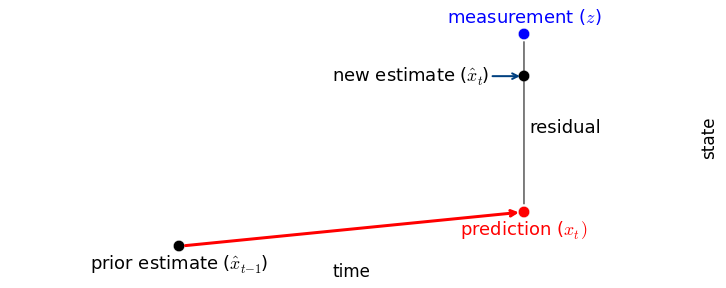

In [4]:
from mkf_internal import show_residual_chart
show_residual_chart()

## Tracking a Dog

Let's go back to our tried and true problem of tracking our dog. This time we will include the fundamental insight of the previous chapter - that of using *hidden variables* to improve our estimates. I could spend a lot of time talking about it, but let's implement a filter, learning as we go. On the surface the math is different and perhaps more complicated than the previous chapters, but the ideas are all the same. There are more things to do, so I have broken it up into a series of steps **blah**

I have programmed the equations of the Kalman filter into the `KalmanFilter` class in FilterPy. You will import it with

```python
from filterpy.kalman import KalmanFilter```

## Initialization - Choose the State Variables and Set Initial Conditions

### **Step 1**: Design State Variable as a Multivariate Gaussian

In the univariate chapter we tracked a dog in one dimension by using a Gaussian. The mean $(\mu)$ represented the most likely position, and the variance ($\sigma^2$) represented the probability distribution of the position. In that problem the position is the *state* of the system, and we call $\mu$ the *state variable*.

In this problem we will be tracking both the position and velocity of the dog, so we have two state variables. It is important to understand that this is a design choice with implications and assumptions that we are not yet prepared to explore. For example, we could also track acceleration, or even jerk.

State variables can either be *observed variables* - directly measured by a sensor, or *hidden variables* - inferred from the observed variables. For our dog tracking problem the sensor reads position, so position is observed and velocity is hidden. 

In the previous chapter we would represent the dog's position as:

$$\mu = 3.2$$

In the last chapter we learned to use a multivariate Gaussian. For example, if we wanted to specify a position of 10.0 m and a velocity of 4.5 m/s, we would write:

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

The Kalman filter is implemented using linear algebra. We use an $n\times 1$ matrix (usually called a **vector**) to store  $n$ state variables. For the dog tracking problem, we use $x$ to denote position, and the first derivative of $x$, $\dot{x}$, for velocity. The Kalman filter equations use $\mathbf{x}$ for the state, so we define $\mathbf{x}$ as:

$$\mathbf{x} =\begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

We use $\mathbf{x}$ instead of $\mu$, but recognize this is the mean of the multivariate Gaussian. It is common to use the transpose notation to write the state variable as $\mathbf{x} =\begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathsf{T}$ because the transpose of a row vector is a column vector. This notation is easier to use in running text because it takes less vertical space.

Let's code this. FilterPy's `KalmanFilter` class contains a variable `x` for the state variable. Initialization of `x` is as simple as

In [5]:
from filterpy.kalman import KalmanFilter
kf = KalmanFilter(dim_x=2, dim_z=1)

kf.x = np.array([[10.0],
                 [4.5]])
kf.x

array([[ 10. ],
       [  4.5]])

I often use the transpose trick in my code to turn a row matrix into a vector:

In [6]:
kf.x = np.array([[10.0, 4.5]]).T
kf.x                

array([[ 10. ],
       [  4.5]])

However, NumPy recognizes 1D arrays as vectors, so I can simplify this line to use a 1D array.

In [7]:
kf.x = np.array([10.0, 4.5])

That's it; the state vector is designed and implemented.

One point that might be confusing: $\mathbf{x}$ and $x$ somewhat coincidentally have the same name. If we were tracking the dog in the y-axis we would write $\mathbf{x} =\begin{bmatrix}y & \dot{y}\end{bmatrix}^\mathsf{T}$. 

The other half of the multivariate Gaussian is the covariance $\Sigma$. Kalman filter equations typically use the symbol $\mathbf{P}$. In the one dimensional Kalman filter we specified an initial value for $\sigma^2$, and then the filter took care of updating its value as measurements were added to the filter. The same thing happens in the multidimensional Kalman filter. We specify an initial value for $\mathbf{P}$ and the filter updates it during each predict and update step.

We need to set the variances to reasonable values. For example, we may choose $\sigma_\mathtt{pos}^2=500 m^2$ if we are quite uncertain about the initial position. Top speed for a dog is around 20 m/s, so in the absence of any other information about the velocity we can set $\sigma_\mathtt{vel}=20$, or $\sigma_\mathtt{vel}^2=400$. 

In the last chapter we showed that the position and velocities are correlated. But how correlated are they for a dog? I have no idea. As we will see the filter computes this for us, so I initialize the covariances to zero. Of course if you know the covariancies you should use them.

Recall that the diagonals of the covariance matrix contains the variance of each variable, and the off-diagonal elements contains the covariances. To initialize the Kalman filter to the values in the previous paragraph we would write:

$$
\mathbf{P} = \begin{bmatrix}500 & 0 \\ 0&400\end{bmatrix}
$$

There are better initialization schemes than this - typically we use the first measurement to determine the values for $\mathbf{x}$, but we will need to know a bit more before I can explain it. A Kalman filter can recover from poor initialization, so for now this scheme is fine.

Let's write the code for that. Here I take advantage of the function `numpy.diag` which creates a diagonal matrix from the values for the diagonal. Recall from linear algebra that a diagonal matrix is one with zeros in the off-diagonal elements.

In [8]:
kf.P = np.diag([500, 400])
kf.P

array([[ 500.,    0.],
       [   0.,  400.]])

I could have been explicit. This creates the same value:

In [9]:
kf.P = np.array([[500., 0.],
                 [0., 400.]])
kf.P

array([[ 500.,    0.],
       [   0.,  400.]])

We are done. We've expressed the state of the filter as a multivariate Gaussian and implemented it in code.

## Predict Step

The next step in designing a Kalman filter is telling it how to predict the state (mean and covariance) of the system for the next time step. We do this by providing it with equations that describe the physical model of the system.


###  **Step 2:** Design the State Transition Function

In the univariate chapter we modeled the dog's motion with

$$ x = v \Delta t + x_0$$

and implemented it with

```python
def predict(pos, variance, movement, movement_variance):
    return (pos + movement, variance + movement_variance)```
        
If the current position is 5.4 meters, and the movement is 1.1 meters over the time step, then of course the new position is 5.4 + 1.1, or 6.5 meters.

We will do the same thing in this chapter, using multivariate Gaussians instead of univariate Gaussians. You might imagine this sort of implementation:

$$ \mathbf{x} = \begin{bmatrix}10.0\\4.5\end{bmatrix}, \, \, 
d\mathbf{x} =  \begin{bmatrix}1.2\\0.\end{bmatrix} \\
\mathbf{x} = \mathbf{x} + d\mathbf{x}$$

But we need to generalize this. The Kalman filter equations work with *any* linear system, not just Newtonian ones. Maybe the system you are filtering is the plumbing system in a chemical plant, and the amount of flow in a given pipe is determined by a linear combination of the settings of different valves. 

$$\mathtt{pipe_1 flow} = 0.134  (\mathtt{valve}_1) + 0.41(\mathtt{valve}_2 - \mathtt{valve}_3) + .34 \\
\mathtt{pipe_2 flow} = 0.21  (\mathtt{valve}_2) - 0.6(\mathtt{valve}_1 - \mathtt{valve}_5) + 1.86$$

Linear algebra has a powerful way to express systems of equations. Take this system

$$\begin{cases}
2x+3y=8\\3x-y=1
\end{cases}$$

We can put this in matrix form by writing:

$$\begin{bmatrix}2& 3 \\ 3&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\1\end{bmatrix}$$

If you perform the matrix multiplication in this equation the result will be the two equations above. In linear algebra we would write this as $\mathbf{Ax}=\mathbf{b}$, where

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 3&-1\end{bmatrix},\, \mathbf{x} = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf{b}=\begin{bmatrix}8\\1\end{bmatrix}$$

We call the set of equations that describe how the systems behaves the **process model**. We use the process model to perform the innovation, because the equations tell us what the next state will be given the current state. Kalman filters implement this using the linear equation, where $\mathbf{x}^-$ is the *prior*, or predicted state:

$$\mathbf{x}^- = \mathbf{Fx}$$

Our job as Kalman filters designers is to specify $\mathbf{F}$ such that $\mathbf{x}^- = \mathbf{Fx}$ performs the innovation (prediction) for our system. To do this we need one equation for each state variable. In our problem $\mathbf{x} = \begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathtt{T}$, so we need one equation for $x$ and a second one for $\dot{x}$ . We already know the equation for the position innovation:

$$x^- = \dot{x} \Delta t + x$$

What is our equation for velocity ($\dot{x}$)? Unfortunately, we have no predictive model for how our dog's velocity will change over time. In this case we assume that it remains constant between innovations. Of course this is not exactly true, but so long as the velocity doesn't change *too much* over each innovation you will see that the filter performs very well. So we say

$$\dot{x}^- = \dot{x}$$

This gives us the process model for our system 

$$\begin{aligned}
x^- &= \dot{x} \Delta t + x \\
\dot{x}^- &= \dot{x}
\end{aligned}$$

We need to express this set of equations in the form $\mathbf{x}^- = \mathbf{Fx}$. Let me rearrange terms to make it easier to see what to do.

$$\begin{aligned}
x^- &= 1x + &\Delta t \dot{x} \\
\dot{x}^- &=0x + &\dot{x}
\end{aligned}$$

We can rewrite this in matrix form as

$$\begin{aligned}
{\begin{bmatrix}x\\\dot{x}\end{bmatrix}}^- &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot{x}\end{bmatrix}\\
\mathbf{x}^- &= \mathbf{Fx}
\end{aligned}$$

$\mathbf{F}$ is often called the **state transition function**. In the `KalmanFilter` class we implement the state transition function with

In [10]:
dt = 0.1
kf.F = np.array([[1, dt],
                 [0, 1]])
kf.F

array([[ 1. ,  0.1],
       [ 0. ,  1. ]])

Let's test this! `KalmanFilter` has a `predict` method that performs the prediction by computing $\mathbf{x}^- = \mathbf{Fx}$. Let's call it and see what happens. We've set the position to 10.0 and the velocity to  0.45 meter/sec. We've defined `dt=0.1`, which means the time step is 0.1 seconds, so we expect the new position to be 10.45 meters after the innovation. The velocity should be unchanged.

In [11]:
kf.x = np.array([10.0, 4.5])
kf.Q = 0     # amount of noise in the system, we haven't learned this yet.
kf.predict()
print(kf.x)

[ 10.45   4.5 ]


This worked. Note that the code does not distinguish between between the *prior* and *posterior* in the variable names, so after calling predict the prior $\mathbf{x}^-$ is stored in `KalmanFilter.x`. If we call `predict()` several times in a row the value will be updated each time.

In [12]:
kf.predict()
print(kf.x)
kf.predict()
print(kf.x)

[ 10.9   4.5]
[ 11.35   4.5 ]


###  **Step 3**: Design the Process Noise Matrix

`KalmanFilter.predict()` computes both the mean and covariance of the innovation. This is the value of $\mathbf{P}$ after three innovations (predictions).

In [13]:
kf.P

array([[ 536.,  120.],
       [ 120.,  400.]])

Inspecting the diagonals shows us that the position variance got larger. We've performed three prediction steps with no measurements, and our uncertainty grew. The off-diagonal elements became non-zero - the Kalman filter detected a correlation between position and velocity! The variance of the velocity did not change.

Here I plot the covariance before and after the predictions. The intial value is in solid red, and the final value is in dashed black.

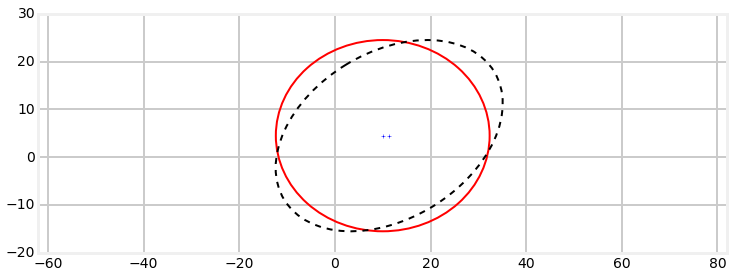

In [14]:
from filterpy.stats import plot_covariance_ellipse
x = np.array([10.0, 4.5])
P = np.array([[500., 0], [0, 400.]])
plot_covariance_ellipse(x, P, edgecolor='r')

x = np.array([11.35, 4.5])
P = np.array([[564., 160], [160, 400.]])
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

How does the filter compute new values for $\mathbf{P}$, and what is it based on? It's a little to early to discuss this, but recall that in every filter so far the predict step entailed a loss of information. The same is true here. I will give you the details once we have covered a bit more ground.

<u>**Process Noise**</u>

A quick review on **process noise**. A car is driving along the road with the cruise control on; it should travel at a constant speed. We model this with $x=\dot{x}\Delta t + x_0$. However, it is affected by a number of unknown factors. The cruise control is not perfect, and cannot maintain a constant velocity. Winds affect the car, as do hills and potholes. Passengers roll down windows, changing the drag profile of the car. 

We can model this system with the differential equation

$$\dot{\mathbf{x}} = \mathbf{Fx} + w$$

where $\mathbf{Fx}$ models the state transition and $w$ is white process noise.

To account for the unmodelled behavior in the system the filter adds a **process noise** covariance matrix $\mathbf{Q}$ to the covariance $\mathbf{P}$. We do not add anything to $\mathbf{x}$ because the noise is *white* - which means that the mean of the noise will be 0. If the mean is 0, $\mathbf{x}$ will not change.

The univariate Kalman filter used `variance = variance + process_noise` to compute the variance for the variance of the prediction step. The multivariate Kalman filter does exactly the same thing, essentially `P = P + Q`. I say 'essentially' because there are other terms unrelated to noise in the covariance equation that we will see later.

Computing the process noise matrix can be quite demanding, and we will put it off until the Kalman math chapter. For now I will say that $\mathbf{Q}$ equals the *expected value* of the white noise $w$. ($\mathbf{Q} = E[\mathbf{ww}^\mathsf{T}]$). In this chapter we will focus on building an intuitive understanding on how modifying this matrix alters the behavior of the filter. FilterPy provides functions which compute $\mathbf{Q}$ for the kinematic problems of this chapter.

In [15]:
from filterpy.common import Q_discrete_white_noise
help(Q_discrete_white_noise)

Help on function Q_discrete_white_noise in module filterpy.common.discretization:

Q_discrete_white_noise(dim, dt=1.0, var=1.0)
    Returns the Q matrix for the Discrete Constant White Noise
    Model. dim may be either 2 or 3, dt is the time step, and sigma is the
    variance in the noise.
    
    Q is computed as the G * G^T * variance, where G is the process noise per
    time step. In other words, G = [[.5dt^2][dt]]^T for the constant velocity 
    model.
    
    **Paramaeters**
    
    dim : int (2 or 3)
        dimension for Q, where the final dimension is (dim x dim)
    
    dt : float, default=1.0
        time step in whatever units your filter is using for time. i.e. the
        amount of time between innovations
    
    var : float, default=1.0
        variance in the noise



This code computes $\mathbf{Q}$ for white noise with a variance of 2.35 and a time step of 0.1 seconds.

In [16]:
kf.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=2.35)
kf.Q

array([[ 0.00005875,  0.001175  ],
       [ 0.001175  ,  0.0235    ]])

### **Step 4**: Design the Control Function

The Kalman filter does not just filter data, it allows us to incorporate control inputs for systems like robots and airplanes. Suppose we are controlling a robot. At each time step we would send control signals to the robot based on its current position vs desired position. Kalman filter equations incorporate that knowledge into the filter equations, creating a predicted position based both on current velocity *and* control inputs to the drive motors. Remember, we *never* throw information away.

For a linear system the effect of control inputs can be described as a set of linear equations, which we can express with linear algebra as

$$\mathbf{Bu}$$

Here $\mathbf{u}$ is the control input, and $\mathbf{B}$ is the control input model. For example, $\mathbf{u}$ might be a voltage controlling how fast the wheel's motor turns, and multiplying by $\mathbf{B}$ yields $[\begin{smallmatrix}x\\\dot{x}\end{smallmatrix}]$.


Therefore the complete Kalman filter equation for the prior mean is

$$\mathbf{x^-} = \mathbf{Fx} + \mathbf{Bu}$$

Your dog may be trained to respond to voice commands. All available evidence suggests that my dog has no control inputs, so I set $\mathbf{B}$ to zero. In Python we write

In [17]:
kf.B = 0.  # my dog doesn't listen to me!


### Prediction: Summary

Your job as a designer is to specify the matrices for
* $\mathbf{x}$: the state variables and initial value
* $\mathbf{P}$: the covariance matrix initial value
* $\mathbf{F}$: the state transition function
* $\mathbf{B}$: Optionally, the control function
* $\mathbf{Q}$: the process noise matrix

## Update Step

Now we can implement the update step of the filter. The good news is that you only have to supply two more matrices, and they are easy to understand. The bad news is that the Kalman filter equations themselves are harder to understand. So for now I'll leave the equations unexplained so we can get the full Kalman filter working. After that we'll look at the equations. 

### **Step 5**: Design the Measurement Function

The Kalman filter computes the update step in what we call **measurement space**. We mostly ignored this issue in the univariate chapter because of the complication it adds. Ee tracked our dog's position using a sensor that reported his position. Computing the *residual* was easy - subtract the filter's predicted position from the measurement:

$$ \mathtt{residual} = \mathtt{measured\, position} - \mathtt{estimated\, position}$$

However, consider what would happen if we were trying to track temperature using a thermometer that outputs a voltage corresponding to the temperature reading. The equation for the residual computation would be nonsense; you can't subtract a temperature from a voltage.

$$ \mathtt{residual} = \mathtt{voltage} - \mathtt{temperature}\;\;\;(BAD!)$$


We need to convert the temperature into a voltage so we can perform the subtraction. For the thermometer it might read:

```python
CELSIUS_TO_VOLTS = 0.21475
residual = measurement - CELSIUS_TO_VOLTS * predicted_state```
    
The Kalman filter generalizes this problem by having you supply a **measurement function** that converts a state into a measurement. 

But why are we working in measurement space? Why not work in state space? Isn't that easier? No, it is not. Consider. Our state is $\begin{bmatrix}x&\dot{x}\end{bmatrix}^\mathsf{T}$. It contains the *hidden* variable $\dot{x}$. There is no way to directly convert a measurement of $x$ into a state $\begin{bmatrix}x&\dot{x}\end{bmatrix}^\mathsf{T}$. We have to work in measurement space to make the computation of the residual possible.

Both the measurement $\mathbf{z}$ and state $\mathbf{x}$ are vectors so we need to use a matrix to perform the conversion. The Kalman filter equation that performs this step is:

$$\textbf{y} = \mathbf{z} - \mathbf{H x^-}$$

where $\textbf{y}$ is the residual, $\mathbf{x^-}$ is the prior, $\textbf{z}$ is the measurement, and $\textbf{H}$ is the measurement function. So we take the prior, convert it to a measurement, and subtract it from the measurement our sensor gave us. This gives us the difference between our prediction and measurement in measurement space!

We need to design $\mathbf{H}$ so that $\textbf{Hx}^-$ yields a measurement. For this problem we have a sensor that measures position, so $\mathbf{z}$ will be a one variable vector:

$$\mathbf{z} = \begin{bmatrix}z\end{bmatrix}$$

The state is $\mathbf{x}=\begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathsf{T}$ so $\mathbf{H}$ has to be a $1\times 2$ matrix. Recall that multiplying matrices $m\times n$ by $n\times p$ yield one of size $m\times p$. The equation will have the form

$$
\begin{aligned}
\textbf{y} &= \mathbf{z} - \mathbf{H}\mathbf{x^-}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}
$$

We will want to multiply the position $x$ by 1 to get the corresponding measurement of the position, and multiply the velocity $\dot{x}$ by 0 to get the corresponding measurement of velocity (of which there is none).

$$
\textbf{y} = \mathbf{z} - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
$$

And so, for our Kalman filter we set

$$\mathbf{H}=\begin{bmatrix}1&0\end{bmatrix}$$

We implement this as

In [18]:
kf.H = np.array([[1., 0.]])

Believe it or not, we have designed the majority of our Kalman filter! All that is left is to model the noise in our sensors.

### **Step 6**: Design the Measurement Noise Matrix

The **measurement noise matrix** models the noise in our sensors as a covariance matrix. In practice this can be difficult. A complicated system may have many sensors, the correlation between them might not be clear, and usually their noise is not a pure Gaussian. For example, a sensor might be biased to read high if the temperature is high, and so the noise is not distributed equally on both sides of the mean.

In the univariate chapter we used a variance of 5 meters squared for our position sensor. Let's use the same value here.  The Kalman filter equations uses the symbol $\mathbf{R}$ for this matrix. The matrix will have dimension $m{\times}m$, where $m$ is the number of sensors. It is $m{\times}m$ because it is a covariance matrix, as there may be correlations between the sensors. We have only 1 sensor here so we write:

$$R = \begin{bmatrix}5\end{bmatrix}$$

If we had two position sensors, the first with a variance of 5 meters squared, the second with a variance of 3 meters squared, we would write

$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

We put the variances on the diagonal because this is a *covariance* matrix, where the variances lie on the diagonal, and the covariances, if any, lie in the off-diagonal elements. Here we assume there is no correlation in the noise between the two sensors, so the covariances are 0.

For our problem we only have one sensor, so we can implement this as

In [19]:
kf.R = np.array([[5.]])

We have a few shortcuts. `KalmanFilter.R` is initialized to the identity matrix. For this simple problem we could write:

    kf.R *= 5.

Finally, since this is a 1x1 matrix you can just use a scalar.

    kf.R = 5.

## Implementing the Kalman Filter

I've given you all of the code for the filter, but now let's collect it in one place. First we construct an `KalmanFilter` object. We have to specify the number of variable in the state with the `dim_x` parameter, and the number of sensors/measurements with `dim_z`. We have two random variables in the state and one measurement, so we write

In [20]:
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)

Now we initialize the filter's matrices and vectors.

In [21]:
dog_filter.x = np.array([0., 0.])                         # state (location and velocity)
dog_filter.F = np.array([[1., 1.], 
                         [0., 1.]])                       # state transition function
dog_filter.H = np.array([[1., 0.]])                       # Measurement function
dog_filter.R =  5                                         # measurement noise
dog_filter.Q = Q_discrete_white_noise(2, dt=0.1, var=0.1) # process noise
dog_filter.P = np.diag([500., 400.])                      # covariance matrix 

Let's look at this line by line. 

**1**: We assign the initial value for our state. Here we initialize both the position and velocity to zero.

**2**: We set $\textbf{F}=\begin{bmatrix}1&1\\0&1\end{bmatrix}$, as in design step 2 above. 

**3**: We set $\textbf{H}=\begin{bmatrix}1&0\end{bmatrix}$, as in design step 4 above.

**4**: We set $\textbf{R} = \begin{bmatrix}5\end{bmatrix}$. 

**5** We use the `Q_discrete_white_noise()` method to set $\mathbf{Q}$'s variance to 0.1.

**6**: We set $\mathbf{P} = \begin{bmatrix} 500&0\\0&400\end{bmatrix}$

I've rewritten the creation of the Kalman filter to allow you to specify different initial values for `R`, `P`, and `Q` and put it in a helper function. We will be creating and running many of these filters, and this saves us a lot of headaches.

In [22]:
def pos_vel_filter(x, P, R, Q=0.):
    dog_filter = KalmanFilter(dim_x=2, dim_z=1)
    dog_filter.x = np.array([x[0], x[1]]) # (location and velocity)
    dog_filter.F = np.array([[1, 1],
                             [0, 1]])     # state transition matrix
    dog_filter.H = np.array([[1, 0]])     # Measurement function
    dog_filter.R *= R                     # measurement uncertainty
    dog_filter.P *= P                     # covariance matrix 
    if np.isscalar(Q):
        dog_filter.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=Q)
    else:
        dog_filter.Q = Q
    return dog_filter

All that is left is to write the code to run the Kalman filter. 

In [23]:
def filter_dog(data, R=0, Q=0, P=500., initial_x=(0., 0.)):
    """ Filters 'data' using the filter provided by 
    dog_tracking_filter().
    
    'initial_x' optional initializes x to some value other than [0, 0].
    
    returns a tuple of (positions, covariance)
    """
    dog_filter = pos_vel_filter(initial_x, R=R, Q=Q, P=P)
    
    pos, cov = [], []   
    for z in data: 
        # perform the kalman filter steps
        dog_filter.predict()
        dog_filter.update(z)

        pos.append(dog_filter.x)
        cov.append(dog_filter.P)
        
    pos = np.array(pos)
    cov = np.array(cov)
    return (pos, cov)

This is the complete code for the filter, and most of it is
boilerplate. I've made it flexible enough to support several uses in this chapter, so it is a bit verbose. The first function `dog_tracking_filter()` is a helper function that creates a `KalmanFilter` object with specified $\mathbf{R}$, $\mathbf{Q}$ and $\mathbf{P}$ matrices. We've shown this code already, so I will not discuss it more here. 

The function `filter_dog()` implements the filter itself.  Lets work through it line by line. The first line creates the simulation of the DogSensor, as we have seen in the previous chapter.

```python
dog = DogSensor(velocity=1, noise=noise)```

The next line uses our helper function to create a Kalman filter.

```python
dog_filter = dog_tracking_filter(R=R, Q=Q, cov=500.)```

We will want to plot the filtered position, the measurements, and the covariance, so we will need to store them in lists. The next three lines initialize empty lists of length *count* in a Pythonic way.

```python
pos = [None] * count
zs  = [None] * count
cov = [None] * count```

Finally we get to the filter. All we need to do is perform the update and predict steps of the Kalman filter for each measurement. The `KalmanFilter` class provides the two methods `update()` and `predict()` for this purpose. `update()` performs the measurement update step of the Kalman filter, and so it takes a variable containing the sensor measurement. 

Absent the bookkeeping work of storing the filter's data, the for loop reads:

```python
for t in range(count):
    z = dog.sense()
    dog_filter.update (z)
    dog_filter.predict()```

It really cannot get much simpler than that. As we tackle more complicated problems this code will remain largely the same; all of the work goes into setting up the `KalmanFilter` variables; executing the filter is trivial.

Now let's look at the result. Here is some code that calls `filter_track()` and then plots the result. It is fairly uninteresting code, so I will not walk through it. The `DogSimulation` class from the previous chapter has been placed in `DogSimulation.py`. I have also implemented a few plot routines to visualize the data in  `mkf_internal.py`. Both of these are in the *code* subdirectory if you wish to read them.

The Kalman filter is designed as a recursive algorithm - as new measurements come in we immediately create a new estimate. But it is very common to have a set of data that have been already collected which we want to filter. Kalman filters can always be run in a *batch* mode, where all of the measurements are filtered at once. We have implemented this in `KalmanFilter.batch_filter()`. Internally, all the method does is loop over the measurements and collect the resulting state and covariance estimates in arrays.

Here is an alternative form of the last function which uses batch filtering. `batch_filter` returns four NumPy `Array` objects; the first two contain the filtered estimates and covariances (the posteriors), and the last two contain the predicted estimates and covariances (the priors). The priors are useful for smoothing algorithms which we will learn later, but for now they are not useful to us, so I disregard them.

In [24]:
def filter_dog(data, R=0, Q=0, P=500., initial_x=(0., 0.)):
    dog_filter = pos_vel_filter(initial_x, R=R, Q=Q, P=P)  
    pos, cov, _, _ = dog_filter.batch_filter(data)
    return (pos, cov)

In [25]:
from DogSimulation import DogSimulation
from mkf_internal import plot_track

def run_filter(Q, R, P, initial_x=(0.,0.), data=None, count=0, std_scale=1, **kwargs):
    if data is None:
        dog = DogSimulation(velocity=1, measurement_variance=R)
        zs = [dog.move_and_sense() for t in range(count)]
    else:
        zs = data
    ps, cov = filter_dog(data=zs, R=R, Q=Q, P=P, initial_x=initial_x)
    plot_track(ps[:, 0], zs, cov, std_scale, **kwargs)
    return ps, cov

Finally, call it. We will start by filtering 50 measurements with a noise variance of 10 and a process variance of 0.01.

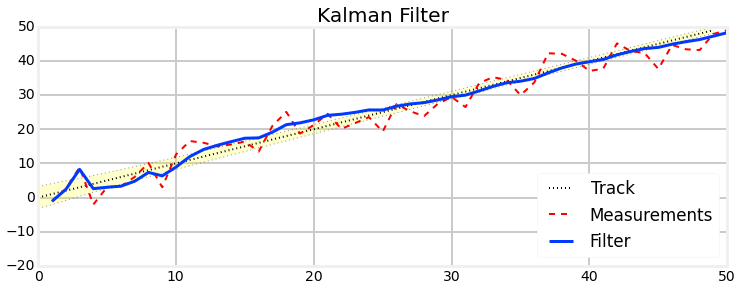

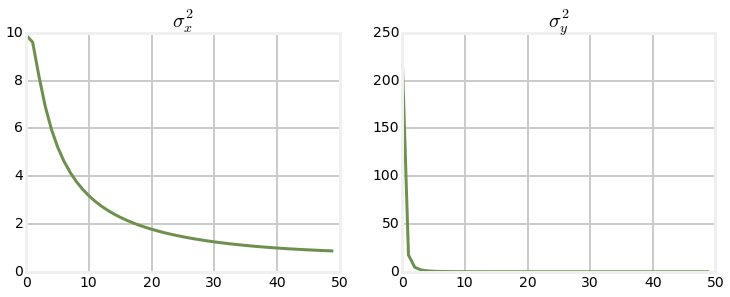

In [26]:
P = np.diag([500., 400.])
Ms, Ps = run_filter(count=50, R=10, Q=0.01, P=P, y_lim=(-20, 50))

There is still a lot to learn, but we have implemented our first, full Kalman filter using the same theory and equations as published by Rudolf Kalman! Code very much like this runs inside of your GPS and phone, inside every airliner, inside of robots, and so on. 

The first plot plots the output of the Kalman filter against the measurements and the actual position of our dog (drawn in green). After the initial settling in period the filter should track the dog's position very closely. The yellow shaded portion between the black dotted lines shows 1 standard deviations of the filter's variance, which I explain in the next paragraph.

The next two plots show the variance of $x$ and of $\dot{x}$. If you look at the code, you will see that I have plotted the diagonals of $\mathbf{P}$ over time. Recall that the diagonal of a covariance matrix contains the variance of each state variable. So $\mathbf{P}[0,0]$ is the variance of $x$, and $\mathbf{P}[1,1]$ is the variance of $\dot{x}$. You can see that despite initializing $\mathbf{P}=(\begin{smallmatrix}500&0\\0&500\end{smallmatrix})$ we quickly converge to small variances for both the position and velocity. The covariance matrix $\mathbf{P}$ tells us the *theoretical* performance of the filter *assuming* everything we tell it is true. Recall from the Gaussian chapter that the standard deviation is the square root of the variance, and that approximately 68% of a Gaussian distribution occurs within one standard deviation. Therefore, if at least 68% of the filter output is within one standard deviation we can be sure that the filter is performing well. In the top chart I have displayed the one standard deviation as the yellow shaded area between the two dotted lines. To my eye it looks like perhaps the filter is slightly exceeding that bounds, so the filter probably needs some tuning. We will discuss this later in the chapter.

In the previous chapter we filtered very noisy signals with much simpler code than the code above. However, realize that right now we are working with a very simple example - an object moving through 1-D space and one sensor. That is about the limit of what we can compute with the code in the last chapter. In contrast, we can implement very complicated, multidimensional filter with this code merely by altering are assignments to the filter's variables. Perhaps we want to track 100 dimensions in financial models. Or we have an aircraft with a GPS, INS, TACAN, radar altimeter, baro altimeter, and airspeed indicator, and we want to integrate all those sensors into a model that predicts position, velocity, and accelerations in 3D (which requires 9 state variables). We can do that with the code in this chapter.

I want you to get a better feel for how the Gaussians change over time, so here is a 3D plot showing the Gaussians from the plot above. I generated this by computing the probability distribution for each over a large area, and then summing them together so I can show them all in the same plot. Note that it makes no mathematical sense to add these together, it is merely a way to display them all at once. The scale of the y axis is much smaller than the x axis, so the Gaussians look very stretched horizontally, but they are not. This scaling makes it easier to see everything and minimizes the amount of computation needed. You should still be able to tell that our certainty in both the position and velocity improve over time. We know this because the Gaussian gets narrow in both axis as time increases, and it simultaneously gets taller.

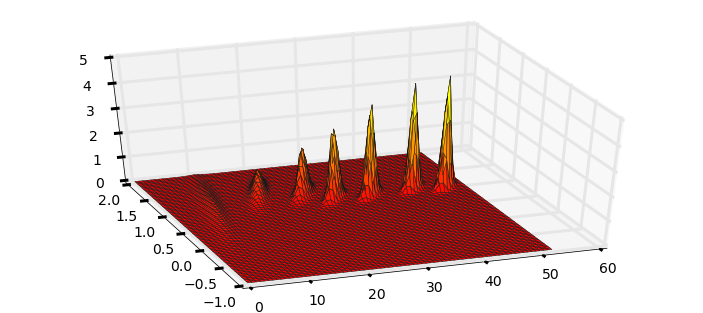

In [27]:
from book_format import set_figsize, figsize
from nonlinear_plots import plot_multiple_gaussians
with figsize(y=5):
    plot_multiple_gaussians(Ms[::7], Ps[::7], (0,52), (-1, 2), 75)

## The Kalman Filter Equations

I've not shown you how `predict()` and `update` perform their computations. In some ways this section is optional, especially if this is your first pass through the book. You'll certainly be able to understand the rest of this section without reading it.

However, most of the difficulties we encounter in Kalman filters result from these equations. If you ever plan to read any other book or paper on the Kalman filter they will not be hiding the equations behind two functions. If you want to grow past this chapter you will need this information. And, it's not that hard. 

A word about my notation. I'm a programmer, and I am used to statements like `x = x + 1`. That is not an equation; the sides are not equal. If we wanted to write this in correct mathematical notation we'd write
$$x_k = x_{k-1} + 1$$

The Kalman filter equations are traditionally *littered* with subscripts and superscripts to keep the equations mathematically consistent. I show then in the summary to this section. But in most of the book I opt for subscriptless statements. As a programmer you should understand that I am showing you an algorithm that is to be executed step by step. I'll elaborate on this once we have a concrete example.

### Prediction Equations

The Kalman filter uses these equations to compute the *prior* - the predicted next state of the system. They compute the mean ($\mathbf{x}$)  and covariance ($\mathbf{P}$) of the system.

$$\begin{aligned}
\mathbf{x}^- &= \mathbf{Fx} + \mathbf{Bu}\\
\mathbf{P}^- &= \mathbf{FPF}^\mathsf{T} + \mathbf{Q}
\end{aligned}$$

<u>**Mean**</u>

$\mathbf{x}^- = \mathbf{Fx} + \mathbf{Bu}$

We are starting out easy - you were already exposed to the first equation while designing the state transition function $\mathbf{F}$ and control function $\mathbf{B}$. 

As a reminder, the linear equation $\mathbf{Ax} = \mathbf{b}$ represents a system of equations, where $\mathbf{A}$ holds the coefficients of the state $\mathbf{x}$. Performing the multiplication $\mathbf{Ax}$ computes the right hand side values for that set of equations.

If $\mathbf{F}$ contains the state transition for a given time step, then the product $\mathbf{Fx}$ computes the state after that transition. Easy! Likewise, $\mathbf{B}$ is the control function, $\mathbf{u}$ is the control input, so $\mathbf{Bu}$ computes the contribution of the controls to the state after the transition.

<u>**Covariance**</u>

$\mathbf{P}^- = \mathbf{FPF}^\mathsf{T} + \mathbf{Q}$

This equation is not as easy to understand so we will spend more time on it. 


In the univariate chapter when we added Gaussians in the predict step we did it this way:

$$\mu = \mu + \mu_1\\
\sigma^2 = \sigma^2 + \sigma^2_1$$

We added the variance of the movement $\mu_1$ to the variance of our estimate to reflect the loss of knowlege. We need to do the same thing here, except it isn't quite that easy with multivariate Gaussians.

In a multivariate Gaussians the state variables are *correlated*. What does this imply? Our knowledge of the velocity is imperfect, but we are adding it to the position with

$$x^- = \dot{x}\Delta t + x$$

Since we do not have perfect knowledge of the value of $\dot{x}$ the sum $x^- = \dot{x}\Delta t + x$ gains uncertainty. Because the positions and velocities are correlated we cannot simply add the covariance matrices. The correct equation is

$$\mathbf{P} = \mathbf{FPF}^\mathsf{T}$$

The expression $\mathbf{FPF}^\mathsf{T}$ is seen all the time in linear algebra. You can think of it as *projecting* the middle term by the outer term. We will be using this many times in the rest of the book. I explain its derivation in the *Kalman Math* chapter. 

For now we will look at its effect. Here I use $\mathbf{F}$ from our filter and project the state forward 6/10ths of a second. I do this five times so you can see how $\mathbf{P}$ continues to change. 

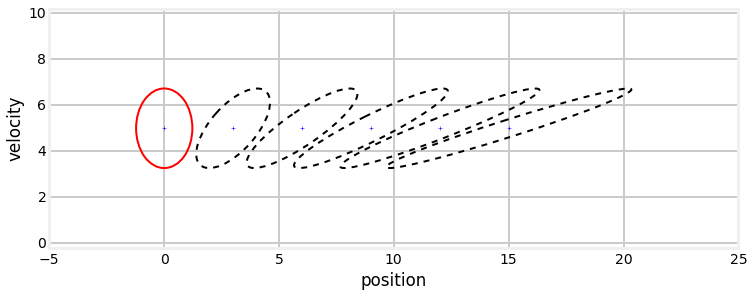

In [28]:
import matplotlib.pyplot as plt
import book_plots
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = np.dot(F, x)
    P = np.dot(F, P).dot(F.T)
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

You can see that with a velocity of 5 the position correctly moves 3 units in each 6/10ths of a second step. At each step the width of the ellipse is larger, indicating that we have lost information asbout the position due to adding $\dot{x}\Delta t$ to x at each step. The height has not changed - our system model say the velocity does not change, so the belief we have about the velocity cannot change. As time continues you can see that the ellipse becomes more and more tilted. Recall that a tilt indicates *correlation*. $\mathbf{F}$ linearly correlates $x$ with $\dot{x}$ with the expression $x^- = \dot{x} \Delta t + x$. The $\mathbf{FPF}^\mathsf{T}$ computation correctly incorporates this correlation into the covariance matrix!

Here is an animation of this equation that allows you to change the design of $\mathbf{F}$ to see how it affects shape of $\mathbf{P}$. The `F00` slider affects the value of F[0, 0]. `covar` sets the intial covariance between the position and velocity($\sigma_x\sigma_{\dot{x}}$). I recommend answering these questions at a minimum

* what if $x$ is not correlated to $\dot{x}$? (set F01 to 0, the rest at defaults)
* what if $x = 2\dot{x}\Delta t + x_0$? (set F01 to 2, the rest at defaults)
* what if $x = \dot{x}\Delta t + 2x_0$? (set F00 to 2, the rest at defaults)
* what if $x = \dot{x}\Delta t$?  (set F00 to 0, the rest at defaults)

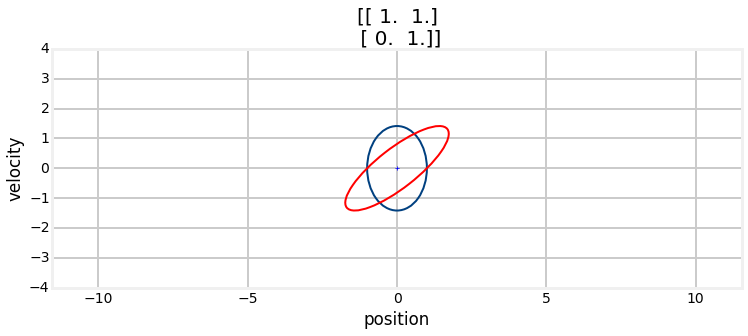

In [29]:
from IPython.html.widgets import interact, interactive, fixed
import IPython.html.widgets as widgets

def plot_FPFT(F00, F01, F10, F11, covar):    
    dt = 1.
    x = np.array((0, 0.))
    P = np.array(((1, covar), (covar, 2)))
    F = np.array(((F00, F01), (F10, F11)))
    plot_covariance_ellipse(x, P)
    plot_covariance_ellipse(x, np.dot(F, P).dot(F.T), edgecolor='r')
    plt.gca().set_aspect('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title(str(F))
    plt.xlabel('position')
    plt.ylabel('velocity')
                 
interact(plot_FPFT, 
         F00=widgets.IntSliderWidget(value=1, min=0, max=2.), 
         F01=widgets.FloatSliderWidget(value=1, min=0., max=2., description='F01(dt)'),
         F10=widgets.FloatSliderWidget(value=0, min=0., max=2.),
         F11=widgets.FloatSliderWidget(value=1, min=0., max=2.),
         covar=widgets.FloatSliderWidget(value=0, min=0, max=1.));

(If you are reading this in a static form: instructions to run this online are here: http://git.io/vmv6e)

### Update Equations

The update equations look messier than the predict equations, but that is mostly due to the Kalman filter computing the update in **measurement space**. This is because measurement are not *invertable*. For example, later on we will be using sensors that only give you the range to a target. It is impossible to convert a range into a position - an infinite number of positions (in a circle) will yield the same range. On the other hand, we can always compute the range (measurement) given a position(state).

Before I continue, recall that we are trying to do something very simple: choose a new estimate chosen somewhere between a measurement and a prediction, as in this chart:

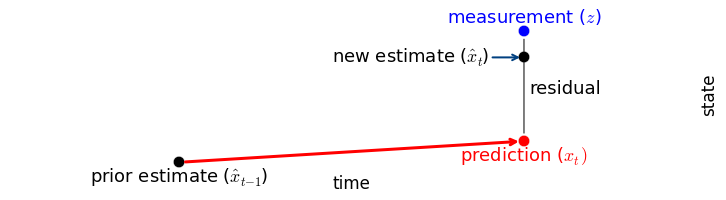

In [30]:
with figsize(y=2.5):
    show_residual_chart()

The equations will be complicted because our state has multiple dimensions, not one, but this is all we are doing. Don't let the equations distract you from the simplicity of this idea.

<u>**System Uncertainty**</u>

$\textbf{S} = \mathbf{HP^-H}^\mathsf{T} + \mathbf{R}$

To work in measurement space the Kalman filter has to project the covariance matrix into measurement space. The math for this is $\mathbf{HP^-H}^\mathsf{T}$, where $\mathbf{P}^-$ is the *prior* covariance and $\mathbf{H}$ is the measurement function.


You should recognize this $\mathbf{ABA}^\mathsf{T}$ form - the prediction step used $\mathbf{FPF}^\mathsf{T}$ to update $\mathbf{P}$ with the state transition function. Here, we use the same form to update it with the measurement function. In a real sense the linear algebra is changing the coordinate system for us. 

Once the covariace is in measurement space we need to account for the sensor noise. This is very easy  - we just add matrices. The result is variously called either the **system uncertainty** or **innovation covariance**.

I want you to compare the equation for the system uncertainty and the covariance


$$\begin{aligned}
\mathbf{S} &= \mathbf{HP^-H}^\mathsf{T} + \mathbf{R}\\
\mathbf{P} &= \mathbf{FPF}^\mathsf{T} + \mathbf{Q}
\end{aligned}$$

You can see that they are performing the same computation. In each $\mathbf{P}$ is put into a different space with either the function $\mathbf{H}$ or $\mathbf{F}$. Once that is done we add the noise matrix associated with that space.

<u>**Kalman Gain**</u>

$\mathbf{K} = \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}$

Look back at the diagram above. Once we have a prediction and a measurement we need to select an estimate somewhere between the two. If we have more certainty about the measurement the estimate will be closer to it. If instead we have more certainty about the prediction then the estimate will be closer to it. 

In the univariate chapter we scaled the mean using this equation

$$
\mu =\frac{\sigma_\mathtt{prior}^2 \mu_2 + \sigma_\mathtt{z}^2 \mu_\mathtt{prior}} {\sigma_\mathtt{prior}^2 + \sigma_\mathtt{z}^2}$$

which lead to this equivalent simplification

$$\mu = (1-K)\mu_\mathtt{prior} + K\mu_\mathtt{z}$$

Here $K$ is the Kalman gain, and it is a scaler between 0 and 1. Examine this equation and ensure you understand how it selects a mean somewhere between the prediction and measurement. In this form the Kalman gain is essentially a *percentage* or *ratio* - if K is .9 it takes 90% of the measurement and 10% of the prediction. 

For the multivariate Kalman filter $\mathbf{K}$ is a vector, not a scalar. Here is the equation again: $\mathbf{K} = \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}$. Is this a *ratio*? We can think of the inverse of a matrix as linear algebra's way of doing matrix division. Division is not defined for matrices, but it is useful to think of it in this way. So we can read the equation for $\textbf{K}$ as meaning

$$\begin{aligned} \textbf{K} &\approx \frac{\textbf{P}\textbf{H}^\mathsf{T}}{\mathbf{S}} \\
\textbf{K} &\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\textbf{H}^\mathsf{T}
\end{aligned}$$

In other words, the *Kalman gain* equation is doing nothing more than computing a ratio based on how much we trust the prediction vs the measurement. If we are confident in our measurements and unconfident in our predictions $\mathbf{K}$ will favor the measurement, and vice versa. The equation is complicated because we are doing this in multiple dimensions via matrices, but the concept is simple - scale by a ratio, same as the univariate case.

Without going into the derivation of $\mathbf{K}$, I'll say that this equation is the result of finding a value of $\mathbf{K}$ that optimizes the *mean-square estimation error*. It does this by finding the minimal values for $\mathbf{P}$ along its diagonal. Recall that the diagonal of $\mathbf{P}$ is the variance for each state variable. So, this equation for $\mathbf{K}$ ensures that the Kalman filter output is optimal. To put this in concrete terms, for our dog tracking problem this means that the estimates for both position and velocity will be optimal in a least squares sense.

<u>**Residual**</u>

$\mathbf{y} = \mathbf{z} - \mathbf{Hx}$

This is an easy one as we've covered this equation while designing the measurement function $\mathbf{H}$. Recall that the measurement function converts a state into a measurement. So $\mathbf{Hx}$ converts $\mathbf{x}$ into an equivalent measurement. Once that is done, we can subtract it from the measurement $\mathbf{z}$ to get the residual - the difference between the measurement and prediction.

<u>**State Update**</u>

$\mathbf{x} = \mathbf{x}^- + \mathbf{Ky}$

We select our new state to be along the residual, scaled by the Kalman gain. The scaling is performed by $\mathbf{Ky}$, which then needs to be added to the prior: $\mathbf{x} =\mathbf{x}^- + \mathbf{Ky}$.

<u>**Covariance Update**</u>

$\mathbf{P} = (\mathbf{I}-\mathbf{KH})\mathbf{P}^-$

$\mathbf{I}$ is the identity matrix, and is the way we represent $1$ in multiple dimensions. $\mathbf{H}$ is our measurement function, and is a constant.  So, simplified, this is simply $\mathbf{P} = (1-c\mathbf{K})\mathbf{P}$. $\mathbf{K}$ is our ratio of how much prediction vs measurement we use. So, if $\mathbf{K}$ is large then $(1-\mathbf{cK})$ is small, and $\mathbf{P}$ will be made smaller than it was. If $\mathbf{K}$ is small, then $(1-\mathbf{cK})$ is large, and $\mathbf{P}$ will be made larger than it was. So we adjust the size of our uncertainty by some factor of the *Kalman gain*.

### Summary

We have learned the Kalman filter equations. Here they are all together for your review. There was a lot to learn, but I hope that as you went through each you recognized it's kinship with the equations in the univariate filter. In the *Kalman Math* chapter I will show you that if we set the dimension of $\mathbf{x}$ to one that these equations revert back to the equations for the univariate filter. This is not "like" the univariate filter - it is a multiple dimension implementation of it.

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u}\;\;\;&(1) \\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}\;\;\;&(2) \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{HP^-H}^\mathsf{T} + \mathbf{R} \;\;\;&(3)\\
\mathbf{K} &= \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}\;\;\;&(4) \\
\textbf{y} &= \mathbf{z} - \mathbf{H x^-} \;\;\;&(5)\\
\mathbf{x} &=\mathbf{x^-} +\mathbf{K\textbf{y}} \;\;\;&(6)\\
\mathbf{P} &= (\mathbf{I}-\mathbf{KH})\mathbf{P^-}\;\;\;&(7)
\end{aligned}
$$

While we are looking at the equations, I want to share a form of the equations that you will see in the literature. No article or book uses the same notation, but this gives you an idea of what to expect.

 $$
\begin{aligned}
\hat{\mathbf{x}}_{k\mid k-1} &= \mathbf{F}_k\hat{\mathbf{x}}_{k-1\mid k-1} + \mathbf{B}_k \mathbf{u}_k  \\
\mathbf{P}_{k\mid k-1} &=  \mathbf{F}_k \mathbf{P}_{k-1\mid k-1} \mathbf{F}_k^\mathsf{T} + \mathbf{Q}_k \\        	
\tilde{\mathbf{y}}_k &= \mathbf{z}_k - \mathbf{H}_k\hat{\mathbf{x}}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf{H}_k \mathbf{P}_{k\mid k-1} \mathbf{H}_k^\mathsf{T} + \mathbf{R}_k \\
\mathbf{K}_k &= \mathbf{P}_{k\mid k-1}\mathbf{H}_k^\mathsf{T} \mathbf{S}_k^{-1}\\
\hat{\mathbf{x}}_{k\mid k} &= \hat{\mathbf{x}}_{k\mid k-1} + \mathbf{K}_k\tilde{\mathbf{y}}_k\\
\mathbf{P}_{k|k} &= (I - \mathbf{K}_k \mathbf{H}_k) \mathbf{P}_{k|k-1}
\\\end{aligned}
$$

The notation above makes heavy use of the Bayesian a$\mid$b notation, which means a given the evidence of b. The hat means estimate. So, $\hat{\mathbf{x}}_{k\mid k}$ means the estimate of the state $\mathbf{X}$ at time $k$ (the first k) given the evidence from time $k$ (the second k). The posterior, in other words. $\hat{\mathbf{x}}_{k\mid k-1}$ means the estimate for the state $\mathbf{x}$ at time k given the estimate from time k - 1. The prior, in other words. 

This notation allows a mathematician to express himself exactly, and when it comes to formal publications presenting new results this precision is necessary. As a programmer I find all of that fairly unreadable; I am used to thinking about variables changing state as a program runs, and do not use a different variable name for each new computation. There is no agreed upon format, so each author makes different choices. I find it challenging to switch quickly between books an papers, and so have adopted my admittedly less precise notation. Mathematicians will write scathing emails to me, but I hope the programmers and students will rejoice.

Here are some examples for how other authors write the prior: $X^*_{n+1,n}$, $\underline{\hat{x}}_k(-)$ (really!), $\hat{\textbf{x}}^-_{k+1}$, $\hat{x}_{k}$. If you are lucky an author defines the notation; more often you have to read the equations in context to recognize what the author is doing. Of course, people write within a tradition; papers on Kalman filters in finance are likely to use one set of notations while papers on radar tracking is likely to use a different set. Over time you will start to become familiar with trends, and also instantly recognize when somebody just copied equations wholesale from another work. For example - the equations I gave above were copied from the  Wikipedia [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter#Details) [[1]](#[wiki_article]) article.

The *Symbology* Chapter lists the notation used by various authors. This brings up another difficulty. Different authors use different variable names. $\mathbf{x}$ is fairly universal, but after that it is anybody's guess. Again, you need to read carefully, and hope that the author defines their variables (they often do not).

If you are a programmer trying to understand a paper's math equations, I suggest starting by removing all of the superscripts, subscripts, and diacriticals, replacing them with a single letter. If you work with equations like this every day this is superfluous advice, but when I read I am usually trying to understand the flow of computation. To me it is far more understandable to remember that $P$ in this step represents the updated value of $P$ computed in the last step, as opposed to trying to remember what $P_{k-1}(+)$ denotes, and what its relation to $P_k(-)$ is, if any, and how any of that relates to the completely different notation used in the paper I read 5 minutes ago.

## Exercise: Show Effect of Hidden Variables

In our filter above velocity is the hidden variable. How would a filter perform if we did not use velocity in the state?

Write a Kalman filter that uses the state $\mathbf{x}=\begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathsf{T}$ and compare it against the filter in the last exercise which used the state $\mathbf{x}=\begin{bmatrix}x\end{bmatrix}$.

In [31]:
# your code here

### Solution

We've already implemented a Kalman filter for position and velocity, so I will provide the code without much comment, and then plot the result.

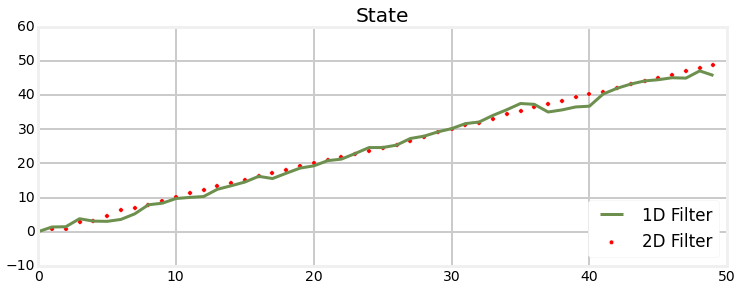

In [32]:
from numpy.random import randn

def mkf_filter(R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.P = 50.
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q = Q
    f.R = R   
    return f

def plot_compare_pos_vel(x0, p0, R, Q, move):
    # storage for filter output
    x1, x2 = [], []

    # initialize the filters
    f1 = mkf_filter(R, Q)
    f1.x[0] = 0.
    f1.P[0, 0] = p0
    
    f2 = pos_vel_filter(x=(0., 1.), P=p0, R=R, Q=Q)
    f2.x[0] = 0.
    f2.x[1] = 1.
    f2.P *= p0
    
    for i in range(50):
        u = move + randn()
        f1.predict(u=u)
        f2.predict(u=u)
        
        z = i*move + randn()
        f1.update(z)
        f2.update(z)
        
        x1.append(f1.x[0, 0])
        x2.append(f2.x[0])

    plt.plot(x1, label='1D Filter')
    plt.scatter(range(len(x2)), x2, c='r', label='2D Filter')
    plt.title('State')
    plt.legend(loc=4)
    plt.xlim([0,50])
    plt.show()
    
plot_compare_pos_vel(x0=0., p0=50., R=5., Q=.2, move=1.)    

### Discussion

The output of the filter that incorporates velocity into the state produces much better output than the filter that only tracks position - the output is much closer to a straight line. We've already discussed why hidden variables increase the precision of the filter, so I will not repeat that explanation here. But this exercise is intended to trigger a train of thought:

1. The equations in this chapter are mathematically equivalent to the equations in the last chapter when we are only tracking one state variable.
    
2. Therefore, the simple Bayesian reasoning we used in the last chapter applies to this chapter as well.

3. Therefore, the equations in this chapter might 'look ugly', but they really implement multiplying and addition of Gaussians.

> The above might not seem worth emphasizing, but as we continue in the book the mathematical demands will increase significantly. It is easy to get lost in a thicket of linear algebra equations when you read a book or paper on optimal estimation. Any time you start getting lost, go back to the basics of the predict/update cycle based on residuals between measurements and predictions and the meaning of the math will usually be much clearer. The math *looks* daunting, and can sometimes be very hard to solve analytically, but the concepts are quite simple.

## Adjusting the Filter

Your results will vary slightly depending on what numbers your random generator creates for the noise component of the noise, but the filter in the last section should track the actual position quite well. Typically as the filter starts up the first several predictions are quite bad, and varies a lot. But as the filter builds its state the estimates become much better. 

Let's start varying our parameters to see the effect of various changes. This is a *very normal* thing to be doing with Kalman filters. It is difficult, and often impossible to exactly model our sensors. An imperfect model means imperfect output from our filter. Engineers spend a lot of time tuning Kalman filters so that they perform well with real world sensors. We will spend time now to learn the effect of these changes. As you learn the effect of each change you will develop an intuition for how to design a Kalman filter. As I wrote earlier, designing a Kalman filter is as much art as science. The science is, roughly, designing the ${\mathbf{H}}$ and ${\mathbf{F}}$ matrices - they develop in an obvious manner based on the physics of the system we are modeling. The art comes in modeling the sensors and selecting appropriate values for the rest of our variables.

Let's look at the effects of the noise parameters ${\mathbf{R}}$ and ${\mathbf{Q}}$. We will want to see the effect of different settings for ${\mathbf{R}}$ and ${\mathbf{Q}}$, so I have hard coded our measurements in `zs` based on a variance of 50 meters squared. That is very large, but it magnifies the effects of various design choices on the graphs, making it easier to recognize what is happening. The behavior of the filter is somewhat dependent on the measurements, so I have hard coded them to ensure we all see the same behavior. Note that I use `numpy.var()` to compute the variance of the data - this is an important tactic that you can use if you are running a filter *off-line*, meaning with collected data rather than real time data.  

variance 240.45554425


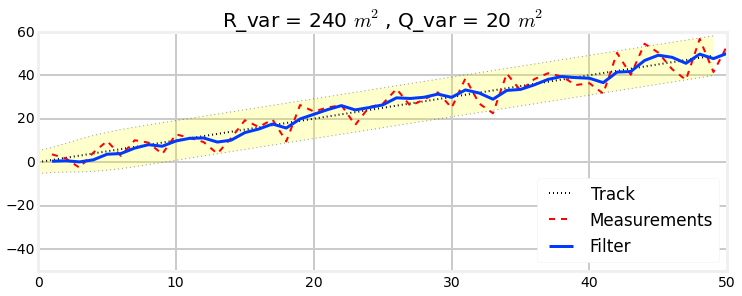

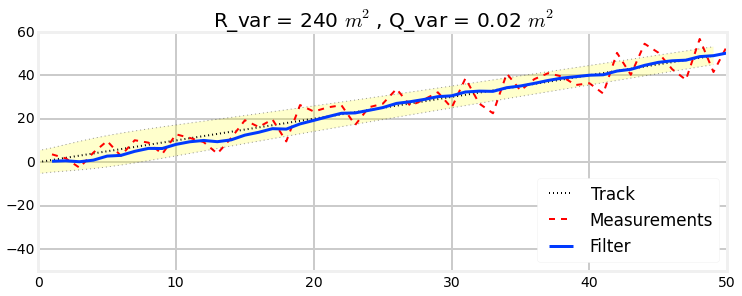

In [33]:
# I've hard coded the measurements to ensure we are all looking 
# at the same data. R~240
zs = [3.59, 1.73, -2.575, 4.38, 9.71, 2.88, 10.08, 8.97, 3.74,
      12.81, 11.15, 9.25, 3.93, 11.11, 19.29, 16.20, 19.63,
      9.54, 26.27, 23.29, 25.18, 26.21, 17.1, 25.27, 26.86,
      33.70, 25.92, 28.82, 32.13, 25.0, 38.56, 26.97, 22.49,
      40.77, 32.95, 38.20, 40.93, 39.42, 35.49, 36.31, 31.56,
      50.29, 40.20, 54.49, 50.38, 42.79, 37.89, 56.69, 41.47, 53.66]
 
print('variance', np.var(zs))
run_filter(data=zs, R=240, Q=200, P=P, plot_P=False, 
           title='R_var = 240 $m^2$, Q_var = 20 $m^2$')

run_filter(data=zs, R=240, Q=.02, P=P, plot_P=False, 
           title='R_var = 240 $m^2$, Q_var = 0.02 $m^2$');

The filter in the first plot should follow the noisy measurement almost exactly. In the second plot the filter should vary from the measurement quite a bit, and be much closer to a straight line than in the first graph. 

In the Kalman filter ${\mathbf{R}}$ is the *measurement noise* and ${\mathbf{Q}}$ is the *process uncertainty*. ${\mathbf{R}}$ is the same in both plots, so ignore it for the moment. Why does ${\mathbf{Q}}$ affect the plots this way?

Let's remind ourselves of what the term *process uncertainty* means. Consider the problem of tracking a ball. We can accurately model its behavior in static air with math, but if there is any wind our model will diverge from reality. 

In the first case we set `Q_var=20 m^2`, which is quite large. In physical terms this is telling the filter "I don't trust my motion prediction step" as we are saying that the variance in the velocity is 10. Strictly speaking, we are telling the filter there is a lot of external noise that we are not modeling with $\small{\mathbf{F}}$, but the upshot of that is to not trust the motion prediction step. So the filter will be computing velocity ($\dot{x}$), but then mostly ignoring it because we are telling the filter that the computation is extremely suspect. Therefore the filter has nothing to use but the measurements, and thus it follows the measurements closely. 

In the second case we set `Q_var=0.02 m^2`, which is quite small. In physical terms we are telling the filter "trust the motion computation, it is really good!". Again, more strictly this actually says there is very small amounts of process noise (variance 0.02 $m^2$), so the motion computation will be accurate. So the filter ends up ignoring some of the measurement as it jumps up and down, because the variation in the measurement does not match our trustworthy velocity prediction.

Now let's set `Q_var` to $0.2\, m^2$, and bump `R_var` up to $10,000\, m^2$. This is telling the filter that the measurement noise is very large. 

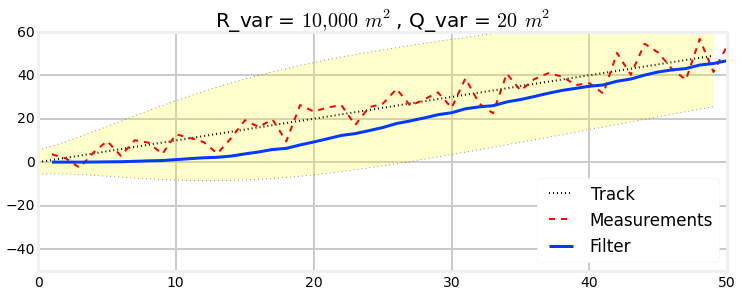

In [34]:
run_filter(data=zs, R=10000, Q=.2, P=P, plot_P=False, std_scale=1., 
           title='R_var = $10,000\, m^2$, Q_var = $20\, m^2$');

The effect of this can be subtle. We have created an suboptimal filter because the actual measurement noise variance is 240 $m^2$, not 10,000 $m^2$. By setting the filter's noise variance so high we force the filter to favor the prediction over the measurement. This can lead to apparently very smooth and good looking results. In the chart above the track may look extremely good to you since it follows the ideal path very closely. But, the 'great' behavior at the start should give you pause - the filter has not converged yet ($\mathbf{P}$ is still large) so it should not be able to be so close to the actual position. We can see that $\mathbf{P}$ has not converged because the entire chart is colored with the yellow background denoting the size of $\mathbf{P}$. Let's make $\mathbf{R}$ larger yet. Let's see the result of a bad initial guess for the position by guessing the initial position to be 20 m and the initial velocity to be 1 m/s.

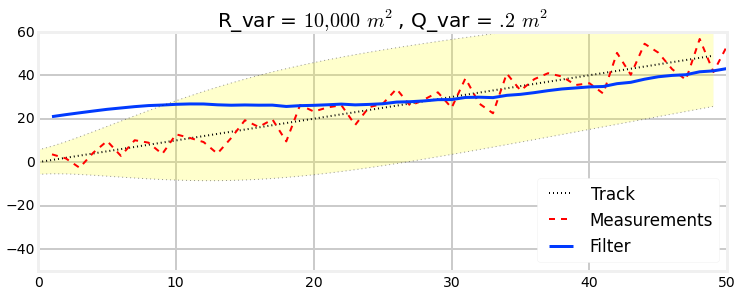

In [35]:
run_filter(data=zs, R=10000, Q=.02, P=P, plot_P=False,
           initial_x=np.array([20., 1.]), std_scale=1.,
           title='R_var = $10,000\, m^2$, Q_var = $.2\, m^2$');

Here we can see that the filter cannot acquire the track. This happens because even though the filter is getting reasonably good measurements it assumes that the measurements are bad, and eventually predicts forward from a bad position at each step. If you think that perhaps that bad initial position would give similar results for a smaller measurement noise, let's set it back to the correct value of 240 $m^2$.

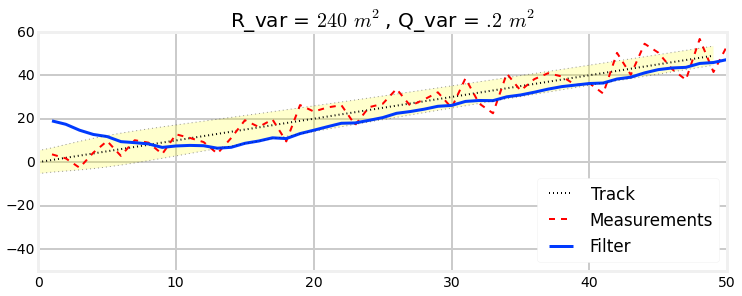

In [36]:
run_filter(data=zs, R=240, Q=.2, P=P, plot_P=False, 
           initial_x=np.array([20., 1.]), std_scale=1.,
           title='R_var = $240\, m^2$, Q_var = $.2\, m^2$');

Here we see that the filter initially struggles for several iterations to acquire the track, but then it accurately tracks our dog. In fact, this is nearly optimum - we have not designed $\mathbf{Q}$ optimally, but $\mathbf{R}$ is optimal, and thus will yield optimal results. Recall that our rule of thumb for the variance of $\mathbf{Q}$ was to set it between $\frac{1}{2}\Delta a$ to $\Delta a$, where $\Delta a$ is the maximum amount that the acceleration will change between sample period. This only applies for the assumption we are making in this chapter - that acceleration is constant and uncorrelated between each time period. In the Kalman Math chapter we will discuss several different ways of designing $\mathbf{Q}$.

To some extent you can get similar looking output by varying either ${\mathbf{R}}$ or ${\mathbf{Q}}$, but I urge you to not 'magically' alter these until you get output that you like. Always think about the physical implications of these assignments, and vary ${\mathbf{R}}$ and/or ${\mathbf{Q}}$ based on your knowledge of the system you are filtering.

## A Detailed Examination of the Covariance Matrix

So far I have not given a lot of coverage of the covariance matrix $\mathbf{P}$. It is nothing more than the variance of our state - such as the position and velocity of our dog. It has many elements in it, but don't be daunted; we will learn how to interpret a very large $9{\times}9$ covariance matrix, or even larger.

Recall the beginning of the chapter, where we provided the equation for the covariance matrix. It read:

$$
\Sigma = \begin{pmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{pmatrix}
$$

(The Kalman filter literature uses $\mathbf{P}$ for $\Sigma$; they both denote the same thing.)

The diagonal contains the variance of each of our state variables. So, if our state variables are

$$\textbf{x}=\begin{bmatrix}x\\\dot{x}\end{bmatrix}$$

and the covariance matrix happens to be

$$\textbf{P}=\begin{bmatrix}2&0\\0&6\end{bmatrix}$$

we know that the variance of $x$ is 2 $m^2$ and the variance of $\dot{x}$ is 6 $(m/s)^2$. The off diagonal elements are all 0, so we also know that $x$ and $\dot{x}$ are not correlated. Recall the ellipses that we drew of the covariance matrices. Let's look at the ellipse for the matrix.

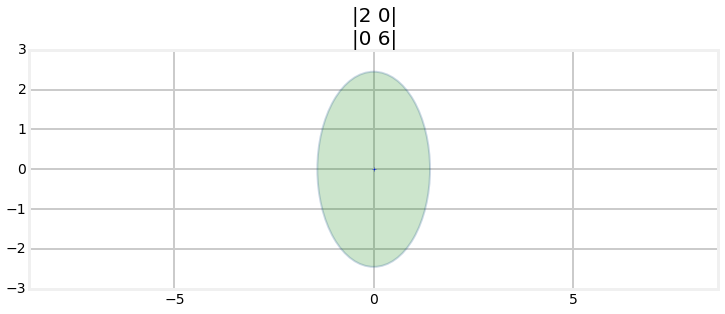

In [37]:
import filterpy.stats as stats

P = np.array([[2., 0.], 
              [0., 6.]])
stats.plot_covariance_ellipse((0, 0), P, facecolor='g', alpha=0.2,
                              title='|2 0|\n|0 6|')

Of course it is unlikely that the position and velocity of an object remain uncorrelated for long. Let's look at a more typical covariance matrix

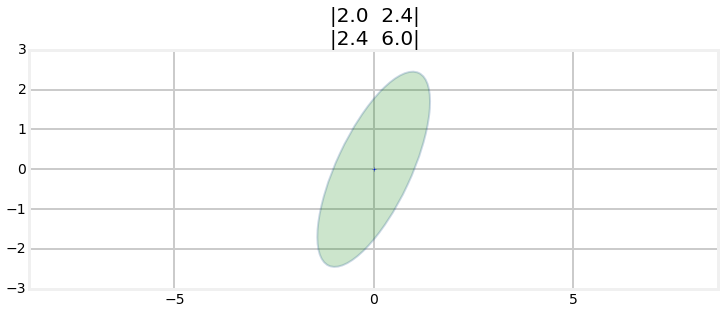

In [38]:
P = np.array([[2.0, 2.4],
              [2.4, 6.0]])
stats.plot_covariance_ellipse((0, 0), P, facecolor='g', alpha=0.2, 
                              title='|2.0  2.4|\n|2.4  6.0|')

Here the ellipse is slanted, signifying that $x$ and $\dot{x}$ are correlated (and, of course, dependent - all correlated variables are dependent). You may or may not have noticed that the off diagonal elements were set to the same value, 2.4. This was not an accident. Let's look at the equation for the covariance for the case where the number of dimensions is two.

$$
\mathbf{P} = \begin{pmatrix}
  \sigma_1^2 & \sigma_{1,2} \\
  \sigma_{2,1} &\sigma_2^2 
 \end{pmatrix}
$$

Here the notation $\sigma_{1,2}$ means the covariance of variables 1 and 2 where that is defined as

$$\sigma_{i,j}
= \mathrm{cov}(X_i, X_j) = \mathrm{E}\begin{bmatrix}
(X_i - \mu_i)(X_j - \mu_j)
\end{bmatrix}$$

We can rearrange the terms to get

$$\begin{aligned}
\sigma_{i,j} &= \mathrm{E}\begin{bmatrix}(X_i - \mu_i)(X_j - \mu_j)\end{bmatrix} \\ 
&= \mathrm{E}\begin{bmatrix} (X_j - \mu_j)(X_i - \mu_i)\end{bmatrix} \\ 
&= \sigma_{j,i}
\end{aligned}$$

In general, we can state that $\sigma_{i,j}=\sigma_{j,i}$.

Let's get back to concrete terms. Let's start by revisiting plotting a track. I will hard code the data and noise to avoid being at the mercy of the random number generator, which might generate data that does not illustrate what I want to talk about. I will start with `P=500`.

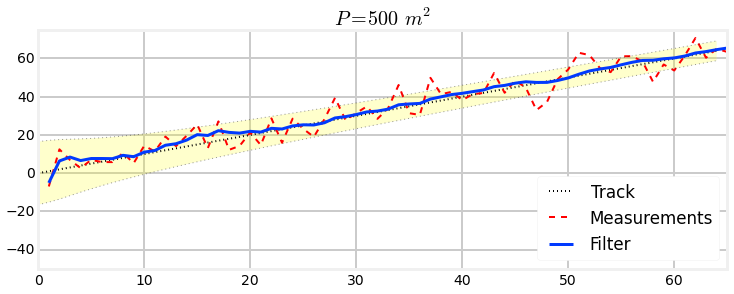

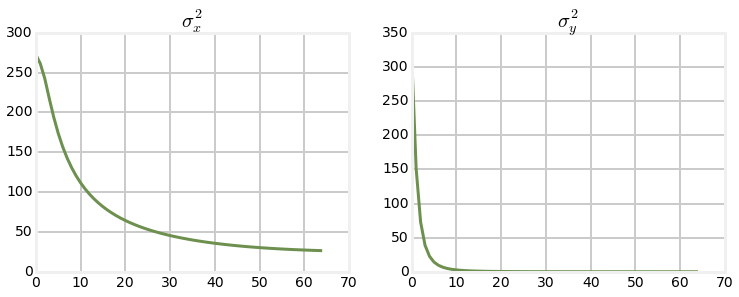

In [39]:
# guarantee the noise is the same each time so I can be sure of
# what the graphs look like.
zs = [-6.947, 12.467, 6.899, 2.643, 6.980, 5.820, 5.788, 10.614, 5.210, 
      14.338, 11.401, 19.138, 14.169, 19.572, 25.471, 13.099, 27.090,
      12.209, 14.274, 21.302, 14.678, 28.655, 15.914, 28.506, 23.181, 
      18.981, 28.197, 39.412, 27.640, 31.465, 34.903, 28.420, 33.889, 
      46.123, 31.355, 30.473, 49.861, 41.310, 42.526, 38.183, 41.383, 
      41.919, 52.372, 42.048, 48.522, 44.681, 32.989, 37.288, 49.141, 
      54.235, 62.974, 61.742, 54.863, 52.831, 61.122, 61.187, 58.441, 
      47.769, 56.855, 53.693, 61.534, 70.665, 60.355, 65.095, 63.386]

var = np.std(zs)**2
run_filter(data=zs, R=var, Q=.2, P=500., plot_P=True, 
           title='$P=500\, m^2$');

Looking at the output we see a very large spike in the filter output at the beginning. If you look at the data (dotted red line) you will see a corresponding, smaller spike in the beginning of the data. We set $P=500\, m^2$, which corresponds to $\text{P}=[\begin{smallmatrix}500&0\\0&500\end{smallmatrix}]$. We now have enough information to understand what this means, and how the Kalman filter treats it. The 500 in the upper left hand corner corresponds to $\sigma^2_x$; therefore we are saying the standard deviation of `x` is $\sqrt{500}$, or roughly 22.36 m. If we recall how standard deviations work, roughly 99% of the samples occur withing $3\sigma$, therefore `P=500` is telling the Kalman filter that the initial estimate could be up to 67 meters off. That is a pretty large error, so when the measurement spikes the Kalman filter distrusts its own estimate and jumps wildly to try to incorporate the measurement. Then, as the filter evolves $\mathbf{P}$ quickly converges to a more realistic value.

Now let us see the effect of a smaller initial value for `P`.

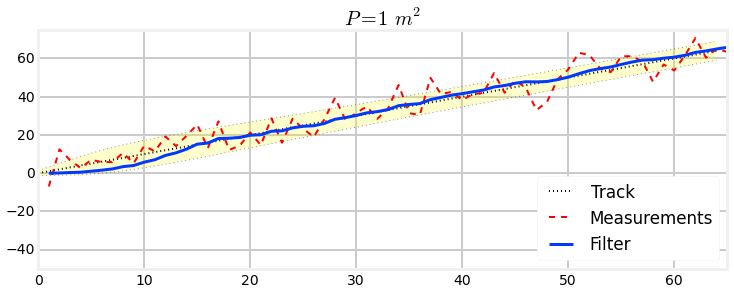

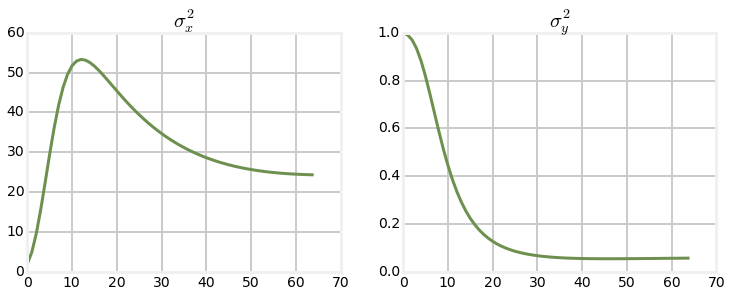

In [40]:
run_filter(data=zs, R=var, Q=.2, P=1., plot_P=True, 
           title='$P=1\, m^2$');

This *looks* good at first blush. The plot does not have the spike that the former plot did; the filter starts tracking the measurements and doesn't take any time to settle to the signal. However, if we look at the plots for P you can see that there is an initial spike for the variance in position, and that it never really converges. Poor design leads to a long convergence time, and suboptimal results. 

So despite the filter tracking very close to the actual signal we cannot conclude that the 'magic' is to use a small $\text{P}$. Yes, this will avoid having the Kalman filter take time to accurately track the signal, but if we are truly uncertain about the initial measurements this can cause the filter to generate very bad results. If we are tracking a living object we are probably very uncertain about where it is before we start tracking it. On the other hand, if we are filtering the output of a thermometer, we are as certain about the first measurement as the 1000th. For your Kalman filter to perform well you must set $\text{P}$ to a value that truly reflects your knowledge about the data. 

Let's see the result of a bad initial estimate coupled with a very small $\text{P}$ We will set our initial estimate at 100 m (whereas the dog actually starts at 0m), but set `P=1 m`.

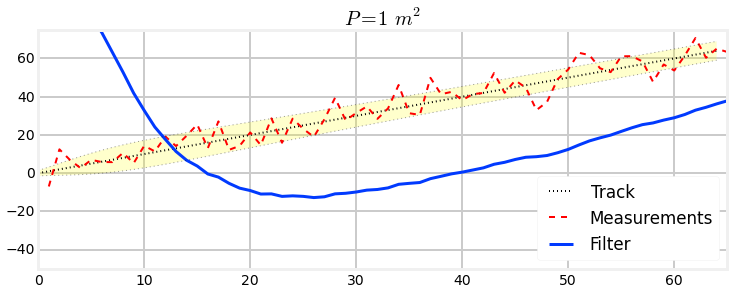

In [41]:
x = np.array([100., 0.]).T

run_filter(data=zs, R=var, Q=.2, P=1., initial_x=x,
           plot_P=False,  title='$P=1\, m^2$');

We can see that the initial estimates are terrible and that it takes the filter a long time to start converging onto the signal . This is because we told the Kalman filter that we strongly believe in our initial estimate of 100 m and were incorrect in that belief.

Now, let's provide a more reasonable value for P and see the difference.

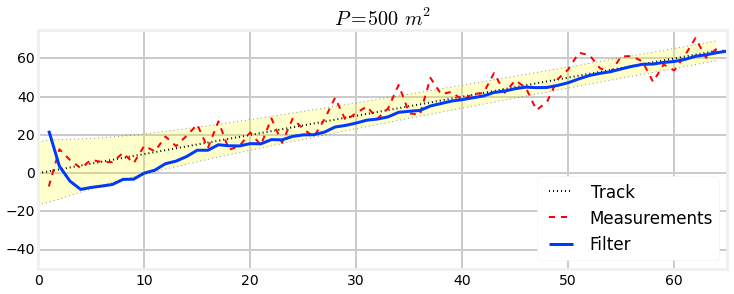

In [42]:
run_filter(data=zs, R=var, Q=.2, P=500., initial_x=x,
           plot_P=False,  title='$P=500\, m^2$');

In this case the Kalman filter is very uncertain about the initial state, so it converges onto the signal much faster. It is producing good output after only 5 to 6 evolutions. With the theory we have developed so far this is about as good as we can do. However, this scenario is a bit artificial; if we do not know where the object is when we start tracking we do not initialize the filter to some arbitrary value, such as 0 m or 100 m. Instead, we would normally take the first measurement, use that to initialize the Kalman filter, and proceed from there. But this is an engineering decision. You really need to understand the domain in which you are working and initialize your filter on the best available information. For example, suppose we were trying to track horses in a horse race. The initial measurements might be very bad, and provide you with a position far from the starting gate. We know that the horse must start at the starting gate; initializing the filter to the initial measurement would lead to suboptimal results. In this scenario we would want to always initialize the Kalman filter with the starting gate position. 

If we have the luxury of not needing to perform the filtering in real time, as the data comes in, we can take advantage of other techniques. We can 'eyeball' the data and see that  the initial measurements are giving us reasonable values for the dog's position because we can see all of the data at once. A *fixed lag smoother* will look N steps ahead before computing the state, and other filters will do things like first run forwards, than backwards over the data. This will be the subject of the Smoothing chapter. It is worthwhile to keep in mind that whenever possible we should prefer this sort of batch processing because it takes advantage of all available information. It does incur cost of additional processing time and increased storage due to the requirement to store some or all of the measurements. And, of course, batch processing does not work if we need real time results, such as when using GPS in our car.

Lets do another Kalman filter for our dog, and this time plot the covariance ellipses on the same plot as the position.

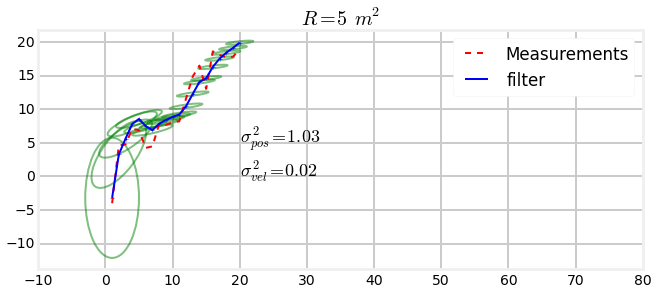

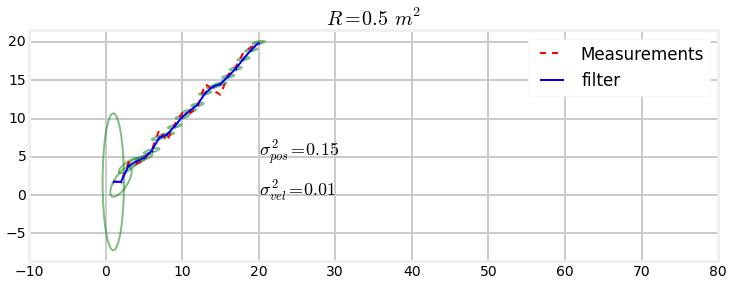

In [43]:
import book_plots as bp
def plot_track_ellipses(noise, count, R, Q=0, P=20., plot_P=True, 
                        title='Kalman Filter'):
    dog = DogSimulation(velocity=1, measurement_variance=noise)
    f = pos_vel_filter(x=(0., 0.), R=R, Q=Q, P=P)

    ps, zs, cov = [], [], []
    for t in range(count):
        z = dog.move_and_sense()
        f.update(z)
        ps.append(f.x[0])
        cov.append(f.P)
        zs.append(z)
        f.predict()

    bp.plot_measurements(range(1,count + 1), zs)
    plt.plot(range(1,count + 1), ps, c='b', lw=2, label='filter')
    plt.legend(loc='best')
    plt.title(title)

    for i,p in enumerate(cov):
        stats.plot_covariance_ellipse(
              (i+1, ps[i]), cov=p, variance=4, axis_equal=False, 
               edgecolor='g', alpha=0.5)

        if i == len(cov)-1:
            s = ('$\sigma^2_{pos} = %.2f$' % p[0,0])
            plt.text (20, 5, s, fontsize=18)
            s = ('$\sigma^2_{vel} = %.2f$' % p[1, 1])
            plt.text (20, 0, s, fontsize=18)
    plt.xlim(-10, 80)
    plt.gca().set_aspect('equal')
    plt.show()

plot_track_ellipses(noise=5, R=5, Q=.2, count=20, title='$R = 5\, m^2$')
plot_track_ellipses(noise=.5, R=.5, Q=.2, count=20, title='$R = 0.5\, m^2$')

If you are viewing this in IPython Notebook or on the web, here is an animation of the filter filtering the data. I've tuned the filter parameters such that it is easy to see a change in $\mathbf{P}$ as the filter progresses.
<img src='animations/multivariate_track1.gif'>

The output on these is a bit messy, but you should be able to see what is happening. In both plots we are drawing the covariance matrix for each point. We start with the covariance $\mathbf{P}=(\begin{smallmatrix}50&0\\0&50\end{smallmatrix})$, which signifies a lot of uncertainty about our initial belief. After we receive the first measurement the Kalman filter updates this belief, and so the variance is no longer as large. In the top plot the first ellipse (the one on the far left) should be a slightly squashed ellipse. As the filter continues processing the measurements the covariance ellipse quickly shifts shape until it settles down to being a long, narrow ellipse tilted in the direction of movement.

Think about what this means physically. The x-axis of the ellipse denotes our uncertainty in position, and the y-axis our uncertainty in velocity. So, an ellipse that is taller than it is wide signifies that we are more uncertain about the velocity than the position. Conversely, a wide, narrow ellipse shows high uncertainty in position and low uncertainty in velocity. Finally, the amount of tilt shows the amount of correlation between the two variables. 

The first plot, with $R=5 m^2$, finishes up with an ellipse that is wider than it is tall. If that is not clear I have printed out the variances for the last ellipse in the lower right hand corner. The variance for position is 3.85 $m^2$, and the variance for velocity is 3.0 $m^2$. 

In contrast, the second plot, with `R=0.5` $m^2$, has a final ellipse that is taller than wide. The ellipses in the second plot are all much smaller than the ellipses in the first plot. This stands to reason because a small $\small\mathbf{R}$ implies a small amount of noise in our measurements. Small noise means accurate predictions, and thus a strong belief in our position. 

## Question: Explain Ellipse Differences

Why are the ellipses for $\mathbf{R}=5 m^2$ shorter, and more tilted than the ellipses for $\mathbf{R}=0.5 m^2$. Hint: think about this in the context of what these ellipses mean physically, not in terms of the math. If you aren't sure about the answer,change $\mathbf{R}$ to truly large and small numbers such as 100 $m^2$ and 0.1 $m^2$, observe the changes, and think about what this means. 

### Solution

The $x$ axis is for position, and $y$ is velocity. An ellipse that is vertical, or nearly so, says there is no correlation between position and velocity, and an ellipse that is diagonal says that there is a lot of correlation. Phrased that way, it sounds unlikely - either they are correlated or not. But this is a measure of the *output of the filter*, not a description of the actual, physical world. When $\mathbf{R}$ is very large we are telling the filter that there is a lot of noise in the measurements. In that case the Kalman gain $\mathbf{K}$ is set to favor the prediction over the measurement, and the prediction comes from the velocity state variable. So, there is a large correlation between $x$ and $\dot{x}$. Conversely, if $\mathbf{R}$ is small, we are telling the filter that the measurement is very trustworthy, and $\mathbf{K}$ is set to favor the measurement over the prediction. Why would the filter want to use the prediction if the measurement is nearly perfect? If the filter is not using much from the prediction there will be very little correlation reported. 

**This is a critical point to understand!**. The Kalman filter is a mathematical model for a real world system. A report of little correlation *does not mean* there is no correlation in the physical system, just that there was no *linear* correlation in the mathematical model. It's a report of how much measurement vs prediction was incorporated into the model.  

Let's bring that point home with a truly large measurement error. We will set $\mathbf{R}=500 m^2$. Think about what the plot will look like before scrolling down. To emphasize the issue, I will set the amount of noise injected into the measurements to 0, so the measurement will exactly equal the actual position. 

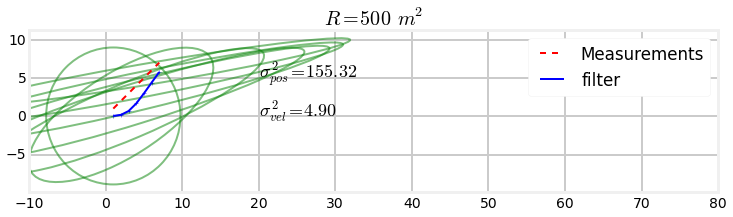

In [44]:
plot_track_ellipses(noise=0., R=500., Q=.2, count=7, title='$R = 500\, m^2$')

I hope the result was what you were expecting. The ellipse quickly became very wide and not very tall. It did this because the Kalman filter mostly used the prediction vs the measurement to produce the filtered result. We can also see how the filter output is slow to acquire the track. The Kalman filter assumes that the measurements are extremely noisy, and so it is very slow to update its estimate for $\dot{x}$. 

Keep looking at these plots until you grasp how to interpret the covariance matrix $\mathbf{P}$. When you start dealing with a, say, $9{\times}9$ matrix it may seem overwhelming - there are 81 numbers to interpret. Just break it down - the diagonal contains the variance for each state variable, and all off diagonal elements are the product of two variances and a scaling factor $p$. You will not be able to plot a $9{\times}9$ matrix on the screen because it would require living in 10-D space, so you have to develop your intuition and understanding in this simple, 2-D case. 

> **sidebar**: when plotting covariance ellipses, make sure to always use ax.set_aspect('equal') or plt.axis('equal') in your code (the former lets you set the xlim and ylim values). If the axis use different scales the ellipses will be drawn distorted. For example, the ellipse may be drawn as being taller than it is wide, but it may actually be wider than tall.

## Filter Initialization


There are many schemes for initializing the filter (i.e. choosing the initial values for $\mathbf{x}$ and $\mathbf{P}$. I will share a common approach that performs well in most situations. In this scheme you do not initialize the filter until you get the first measurement, $\mathbf{z}_0$. From this you can compute the initial value for $\mathbf{x}$ with $\mathbf{x}_0 = \mathbf{z}_0$. If  $\mathbf{z}$ is not of the same size, type, and units as $\mathbf{x}$, which is usually the case, we can use our measurement function as follow.

We know

$$\mathbf{z} = \mathbf{Hx}$$

Hence,

$$\begin{aligned}
\mathbf{H}^{-1}\mathbf{Hx} &= \mathbf{H}^{-1}\mathbf{z} \\
\mathbf{x} &= \mathbf{H}^{-1}\mathbf{z}\end{aligned}$$

Matrix inversion requires a square matrix, but $\mathbf{H}$ is rarely square. SciPy will compute the Moore-Penrose pseudo-inverse of a matrix with `scipy.linalg.pinv`, so your code might look like

In [45]:
import scipy.linalg as la

H = np.array([[1, 0.]]) 
z0 = 3.2

x = np.dot(la.pinv(H), z0)
x

array([[ 3.2],
       [ 0. ]])

Specialized knowledge of your problem domain may lead you to a different computation, but this is one way to do it. 

Now we need to compute a value for $\mathbf{P}$. This will vary by problem, but in general you will use the measurement error $\mathbf{R}$ for identical terms, and maximum values for the rest of the terms. Maybe that isn't clear. In this chapter we have been tracking and object using position and velocity as the state, and the measurements have been positions. In that case we would initialize $\mathbf{P}$ with

$$\mathbf{P} = \begin{bmatrix}\mathbf{R}_0 & 0 \\0 & vel_{max}^2\end{bmatrix}$$

The diagonal of $\mathbf{P}$ contains the variance of each state variable, so we populate it with reasonable values. $\mathbf{R}$ is a reasonable variance for the position, and the maximum velocity squared is a reasonable variance for the velocity. It is squared because variance is squared: $\sigma^2$.

## Batch Processing

The Kalman filter is designed as a recursive algorithm - as new measurements come in we immediately create a new estimate. But it is very common to have a set of data that have been already collected which we want to filter. Kalman filters can always be run in a *batch* mode, where all of the measurements are filtered at once. We have implemented this in `KalmanFilter.batch_filter()`. Internally, all the function does is loop over the measurements and collect the resulting state and covariance estimates in arrays. It simplifies your logic and conveniently gathers all of the outputs into arrays. More importantly, this also allows you to use a smoothing method which generates far better results. I will demonstrate that in the next section. Here I will show you how perform the batch filtering step.

First collect your measurements into an array or list. Maybe it is in a CSV file, for example.

```python
zs = read_altitude_from_csv()```

Or maybe you will generate it using a generator:

```python
zs = [some_func(i) for i in range(1000)]```

Then call the `batch_filter()` method.

```python
Xs, Ps, Xs_pred, Ps_pred = kfilter.batch_filter(zs)```

The function takes the list/array of measurements, filters it, and returns a list of state estimates (Xs), covariance matrices (Ps), and the predictions for the same (Xs_pred, Ps_pred).

Here is a complete example.

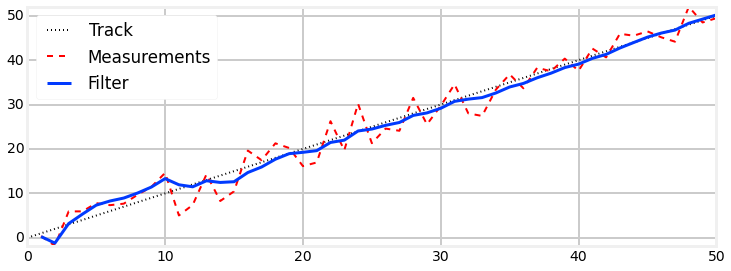

In [46]:
dog = DogSimulation(velocity=1, measurement_variance=10.)
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
count = 50
zs = [dog.move_and_sense() for t in range(count)]
Xs, _, _, _ = f.batch_filter(zs)

bp.plot_track([0, count], [0, count])
bp.plot_measurements(range(1, count + 1), zs)
bp.plot_filter(range(1, count + 1), Xs[:,0])
plt.legend(loc='best');

## Smoothing the Results

I have an entire chapter on using the Kalman filter to smooth data; I will not repeat the chapter's information here. However, it is so easy to use, and offers such a profoundly improved output that I will tease you will a few examples. The smoothing chapter is not especially difficult; you are sufficiently prepared to read it now.

Let's assume that we are tracking a car that has been traveling in a straight line. We get a measurement that implies that the car is starting to turn to the left. The Kalman filter moves the state estimate somewhat towards the measurement, but it cannot judge whether this is a particularly noisy measurement or the true start of a turn. 

However, if we have future measurements we can decide if a turn was made. Suppose the subsequent measurements all continue turning left. We can then be sure that that a turn was initiated. On the other hand, if the subsequent measurements continued on in a straight line we would know that the measurement was noisy and should be mostly ignored. Instead of making an estimate part way between the measurement and prediction the estimate will either fully incorporate the measurement or ignore it, depending on what the future measurements imply about the object's movement.

FilterPy implements a form of this algorithm which is called an *RTS smoother*, after the three inventors of the algorithm: Rauch, Tung, and Striebel. The routine is `KalmanFilter.rts_smoother()`. To use it pass in the means and covariances computed from the `batch_filter` step, and receive back the smoothed means, covariances, and Kalman gain.

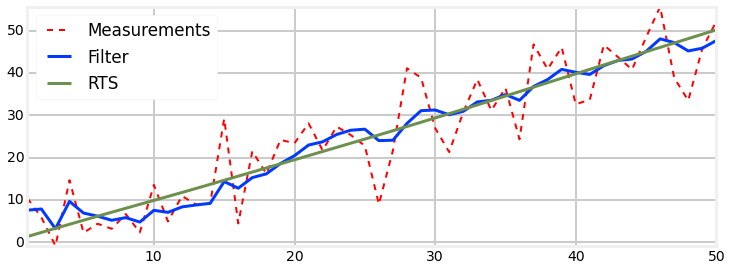

In [47]:
from numpy.random import seed
dog = DogSimulation(velocity=1, measurement_variance=40.)
f = pos_vel_filter(x=(0., 0.), R=3., Q=.2, P=P)
count = 50
seed(8923)
zs = [dog.move_and_sense() for t in range(count)]
xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _ = f.rts_smoother(Xs, Covs)

bp.plot_measurements(range(1, count + 1), zs)
bp.plot_filter(range(1, count + 1), xs[:, 0])
plt.plot(range(1,  count + 1), Ms[:, 0], label='RTS')
plt.legend(loc='best');

This output is fantastic!. Two things are very apparent to me in this chart. First, the RTS output is much, much smoother than the KF output. Second, it is almost always more accurate than the KF output (we will examine this claim in detail in the **Smoothing** chapter).


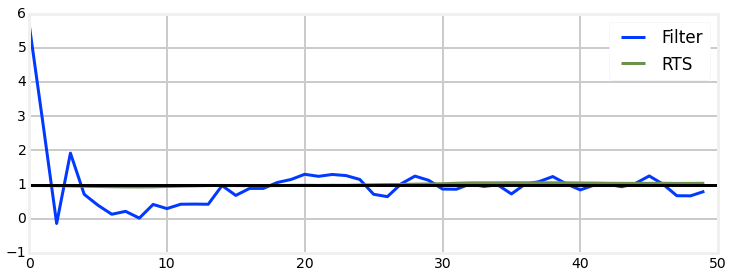

In [48]:
dog = DogSimulation(velocity=1, measurement_variance=40.)
f = pos_vel_filter(x=(0., 0.), R=3., Q=.2, P=P)
count = 50
seed(8923)
zs = [dog.move_and_sense() for t in range(count)]
xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _ = f.rts_smoother(Xs, Covs)
bp.plot_filter(xs[:, 1])
plt.plot(Ms[:, 1], label='RTS')
plt.legend(loc='best')
plt.gca().axhline(1, c='k');

The improvement in the velocity, which is an hidden variable, is even more dramatic. We will explore why this is so in the next exercise.

## Exercise: Compare Velocities

Since we are plotting velocities let's look at what the the 'raw' velocity is, which we can compute by subtracting subsequent measurements. i.e the velocity at time 1 can be approximated by xs[1] - xs[0]. Plot the raw value against the values estimated by the Kalman filter. Discuss what you see.

In [49]:
# your code here

### Solution

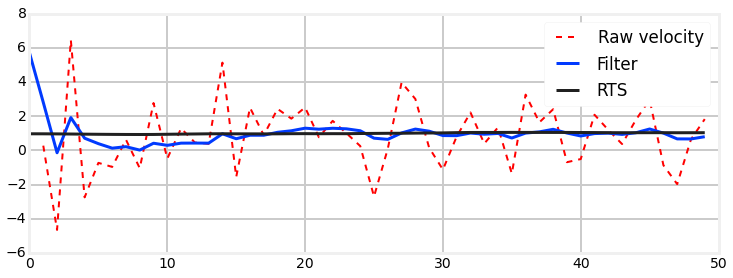

In [50]:
dx = np.diff(xs[:, 0], axis=0)
plt.plot(range(1,count), dx, c='r',ls='--', lw=2, label='Raw velocity')
plt.plot(xs[:, 1], label='Filter')
plt.plot(Ms[:, 1], label='RTS')
plt.legend(loc='best');

We see that the noise swamps the signal, causing the raw values to be essentially worthless. The filter is maintaining a separate estimate for velocity. The Kalman gain $\mathbf{k}$ is multidimensional. For example, it might have the value  $\mathbf{k} = [0.1274, 0.843]^\mathsf{T}$. the first value is used to scale the residual of the position, and the second value will scale the residual of the velocity. The covariance matrix tells the filter how correlated the position and velocity are, and each will be optimally filtered. 

I show this to reiterate the importance of using Kalman filters to compute velocities, accelerations, and even higher order values. I use a Kalman filter even when my measurements are so accurate that I am willing to use them unfiltered because it allows me accurate estimates for velocities and accelerations.

## Discussion and Summary

We extended Gaussians into multiple dimensions to allow us to simultaneously handle multiple dimensions, both spacial and others (velocity, etc). This led us to use linear algebra. We made a key insight: hidden variables have the ability to significantly increase the accuracy of the filter. This counterintuitive result is because the hidden variables are correlated with the observed variables. Intuitively, I think of it as *triangulating* onto the solution - only a small number of states can be true for a given combination of a velocity Gaussian and position Gaussian, roughly described by their intersection. But of course this works for non-spatial problems as well. 

There is one important caveat about hidden variables. It is easy to construct a filter that produces estimates for hidden variables. Heck, I could write a filter that estimates the color of a tracked car.  The designer must verify that these variables are being estimated *correctly*. If you do not have a velocity sensor and yet are estimating velocity, you will need to test that the velocity estimates are correct.; do not trust that they are. For example, suppose the velocity has a periodic component to it - it looks like a sine wave. If your sample time is less than 2 times the frequency you will not be able to accurately estimate the velocity (due to Nyquist's Theorem). Imagine that the sample period is equal to the frequency of the velocity. The filter will report that the velocity is constant because each time it will be sampling the system at the same point on the sin wave. 

Initialization poses a particularly difficult problem for hidden variables. If you start with a bad initialization the filter can usually recover the observed variables, but may struggle and fail with the hidden one. Estimating hidden variables is a powerful tool, but a dangerous one. 

I established a series of steps for designing a Kalman filter. These are not a usual part of the Kalman filter literature, and are only meant as a guide, not a prescription. Designing for a hard problem is an iterative process. You make a guess at the state vector, work out what your measurement and state models are, run some tests, and then alter the design as necessary. 

The design of $\mathbf{R}$ and $\mathbf{Q}$ is often quite challenging. I've made it appear to be quite scientific. Your sensor has Gaussian noise of $\mathcal{N}(0, \sigma^2)$, so set $\mathbf{R}=\sigma^2$. Easy! But I told you a dirty lie. Sensors are not Gaussian. We started the book with a bathroom scale. Suppose $\sigma=1$ kg, and you try to weigh something that weighs 0.5 kg. Theory tells us we will get negative measurements, but of course the scale will never report weights less than zero. Real world sensors typically have *fat tails*, which mean they have more outlying noise than theory predicts. In some cases, such as with the scale, one or both tails are truncated.

The case with $\mathbf{Q}$ is more dire. I hope you were skeptical when I blithely assigned a noise matrix to my prediction about the movements of a dog. Who can say what a dog will do next? But this holds true for more other systems. The GPS in my car doesn't know about hills, the outside winds, or my terrible driving skills. Yet the filter in it requires a precise number to encapsulate all of that information, and it need to work while I drive off-road in the desert, and when Formula One champion Michael Schumacher drives on a closed circuit track.

These problems led some researchers and engineers to derogatorily call the Kalman filter a 'ball of mud'. In other words, it doesn't always hold together so well. Another term to know - Kalman filters can become **smug**. Their estimates are based solely on what you tell it the noises are. Those values can lead to overly confident estimates. $\mathbf{P}$ gets smaller and smaller while the filter is actually becoming more and more inaccurate! In the worst case the filter diverges. We will see a lot of that when we start studying nonlinear filters. 

The reality is that the Kalman filter is a mathematical model of the world. The output is only as accurate as that model. To make the math tractable we had to make some assumptions. I We assume that the sensors and motion model have Gaussian noise. We assume that everything is linear. If that is true, the Kalman filter is *optimal* in a least squares sense. This means that there is no way to make a better estimate than what the filter gives us. However, these assumption are almost never true, and hence the model is necessarily limited, and a working filter is rarely optimal.

In later chapters we will deal with the problem of nonlinearity. For now I want you to understand that designing the matrices of a linear filter is an experimental procedure more than a mathematical one. Use math to establish the initial values, but then you need to experiment. If there is a lot of unaccounted noise in the world (wind, etc) you may have to make $\mathbf{Q}$ larger. If you make it too large the filter fails to respond quickly to changes. In the **Adaptive Filters** chapter you will learn some alternative techniques that allow you to change the filter design in real time in response to the inputs and performance, but for now you need to find one set of values that works for the conditions your filter will encounter. Noise matrices for an acrobatic plane might be different if the pilot is a student than if the pilot is an expert as the dynamics will be quite different.

## References

- <A name="[wiki_article]">[1]</A> 'Kalman Filters'. Wikipedia
https://en.wikipedia.org/wiki/Kalman_filter#Details